### Bank suscription predictor

In this project we will use a Portuguese Bank Marketing Data Set, which you can find on kaggle [here](https://www.kaggle.com/datasets/yufengsui/portuguese-bank-marketing-data-set?resource=download&select=bank-full.csv), to predict a hypothetical term deposit. To do so, we will follow the data science workflow shown in the figure below.
![alt text](datascience_workflow.jpeg "Title")
Since the data is already collected, we will start with the second step, the process of cleaning the dataset.

In [1]:
# We define all the packages needed to carry out the project
# --- Data visualization and data analysis ---
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import time
import itertools
import seaborn as sns
import numpy as np
import scipy
from scipy.stats import uniform
import pandas as pd
import prince
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# --- Machine learning models ---
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingCVClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

# Used to ignore warnings generated from StackingCVClassifier
import warnings
warnings.simplefilter('ignore')

In [2]:
# We import the dataset as a Pandas DataFrame object
data = pd.read_csv('bank-full.csv', sep=';')

# To understand a little bit more about the dataset, we ask Python to give us some information about it
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


It is good to note that there are just object (string) and integer variables in the dataset. This means that all the variables are of $categorical$ type. Also, we have 45211 rows and 17 columns. Let us inspect the values the variables take in each column.

In [3]:
# Let us check if there are missing values in each column of the dataset
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Since the dataset has no missing values because all the values we got above are 0, we are in a good position to tackle the data exploration stage.

In [4]:
# Let us get some statistical information regarding the non-categorical variables of the dataset
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


To better understand the numerical data, we proceed to plot it in histograms. We will plot a histogram for each numerical variable.

In [5]:
# We get the names of numerical variables
name_num = data.select_dtypes([np.number]).columns
print(name_num)

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')


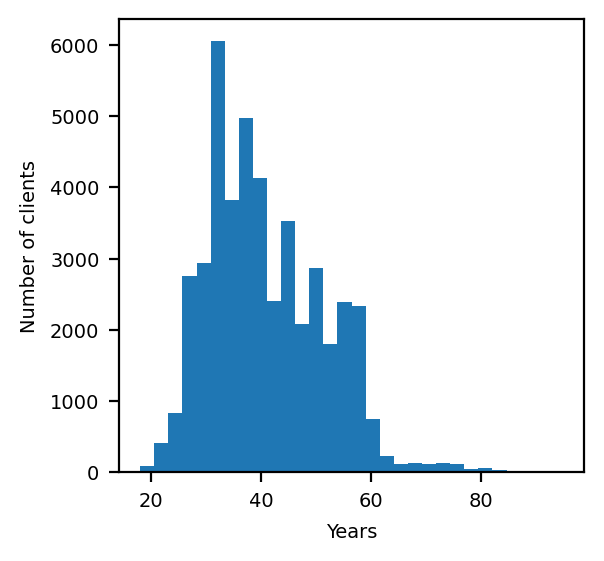

In [6]:
# Histogram of age column
plt.hist(data['age'].values, bins=30, figure=plt.figure(figsize=(3,3), dpi=200))
plt.xlabel('Years', fontsize=7)
plt.ylabel('Number of clients', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

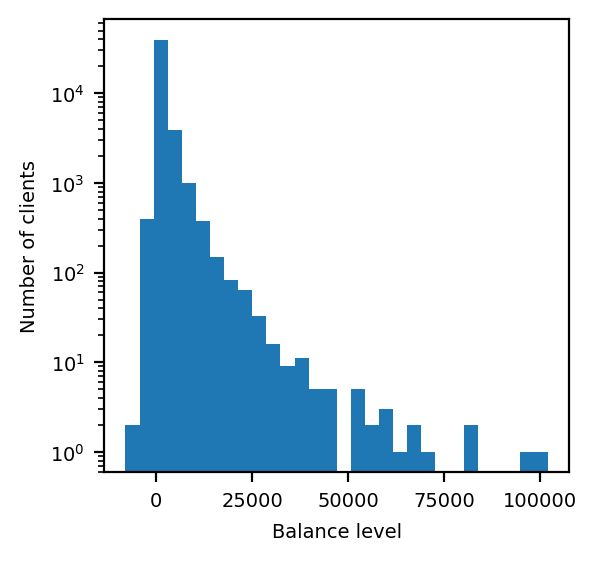

In [7]:
# Histogram of balance column
plt.hist(data['balance'].values, bins=30, figure=plt.figure(figsize=(3,3), dpi=200))
plt.xlabel('Balance level', fontsize=7)
plt.ylabel('Number of clients', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.yscale('log')
plt.show()

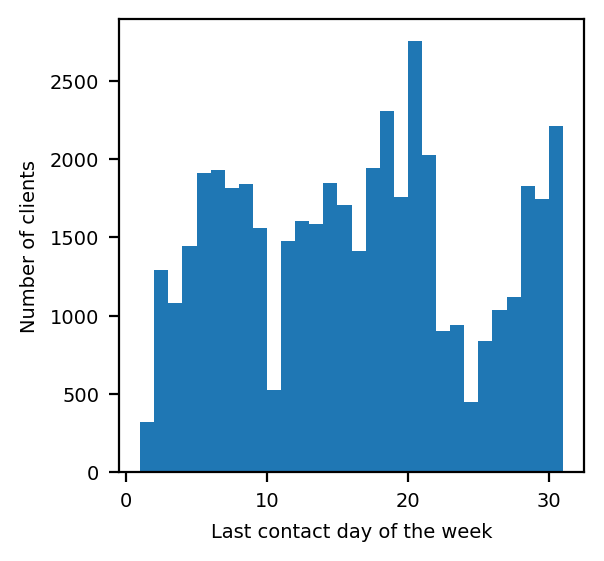

In [8]:
# Histogram of day column
plt.hist(data['day'].values, bins=30, figure=plt.figure(figsize=(3,3), dpi=200))
plt.xlabel('Last contact day of the week', fontsize=7)
plt.ylabel('Number of clients', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

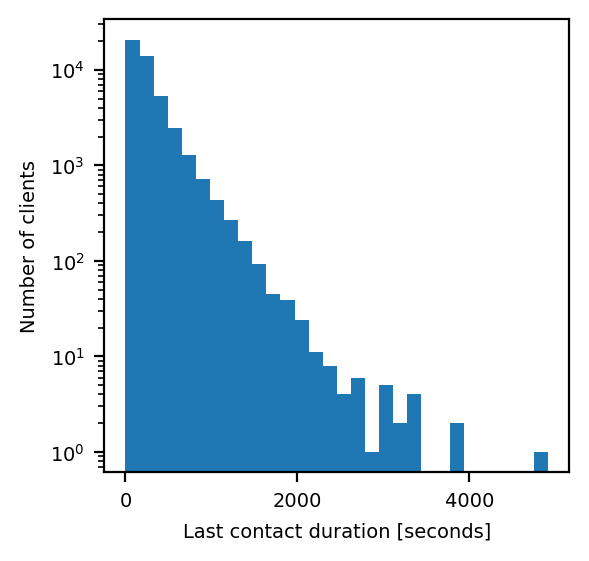

In [9]:
# Histogram of duration column
plt.hist(data['duration'].values, bins=30, figure=plt.figure(figsize=(3,3), dpi=200))
plt.xlabel('Last contact duration [seconds]', fontsize=7)
plt.ylabel('Number of clients', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.yscale('log')
plt.show()

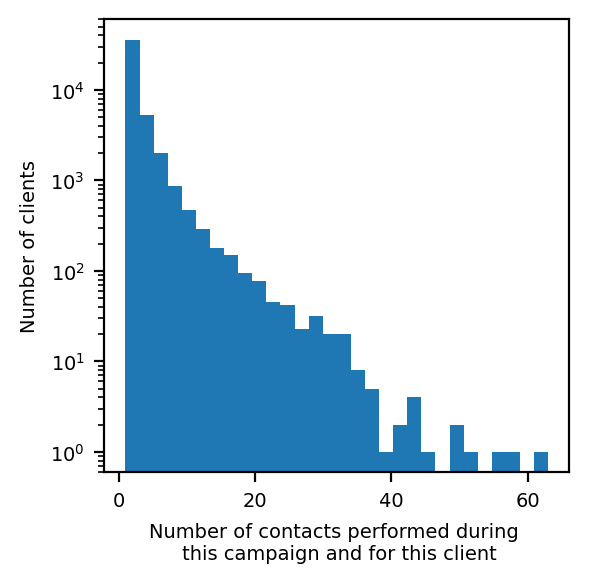

In [10]:
# Histogram of campaign column
plt.hist(data['campaign'].values, bins=30, figure=plt.figure(figsize=(3,3), dpi=200))
plt.xlabel('Number of contacts performed during \n this campaign and for this client', fontsize=7)
plt.ylabel('Number of clients', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.yscale('log')
plt.show()

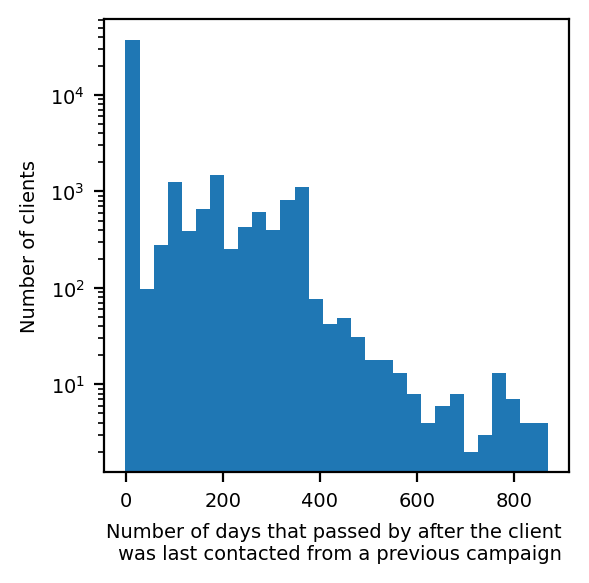

In [11]:
# Histogram of pdays column
plt.hist(data['pdays'].values, bins=30, figure=plt.figure(figsize=(3,3), dpi=200))
plt.xlabel('Number of days that passed by after the client \n was last contacted from a previous campaign', fontsize=7)
plt.ylabel('Number of clients', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.yscale('log')
plt.show()

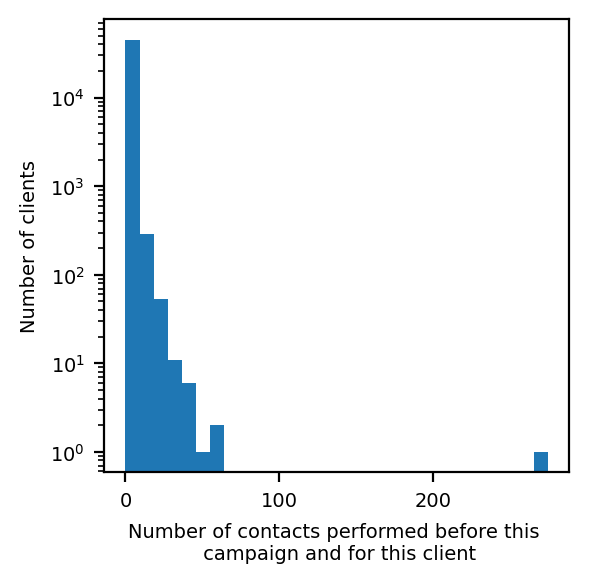

In [12]:
# Histogram of previous column
plt.hist(data['previous'].values, bins=30, figure=plt.figure(figsize=(3,3), dpi=200))
plt.xlabel('Number of contacts performed before this \n campaign and for this client', fontsize=7)
plt.ylabel('Number of clients', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.yscale('log')
plt.show()

Now, we will proceed to make a type of plot similar to the previous ones but for the categorical variables.

In [13]:
# We get the names of the categorical columns
data.select_dtypes(include=['object']).columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'y'],
      dtype='object')

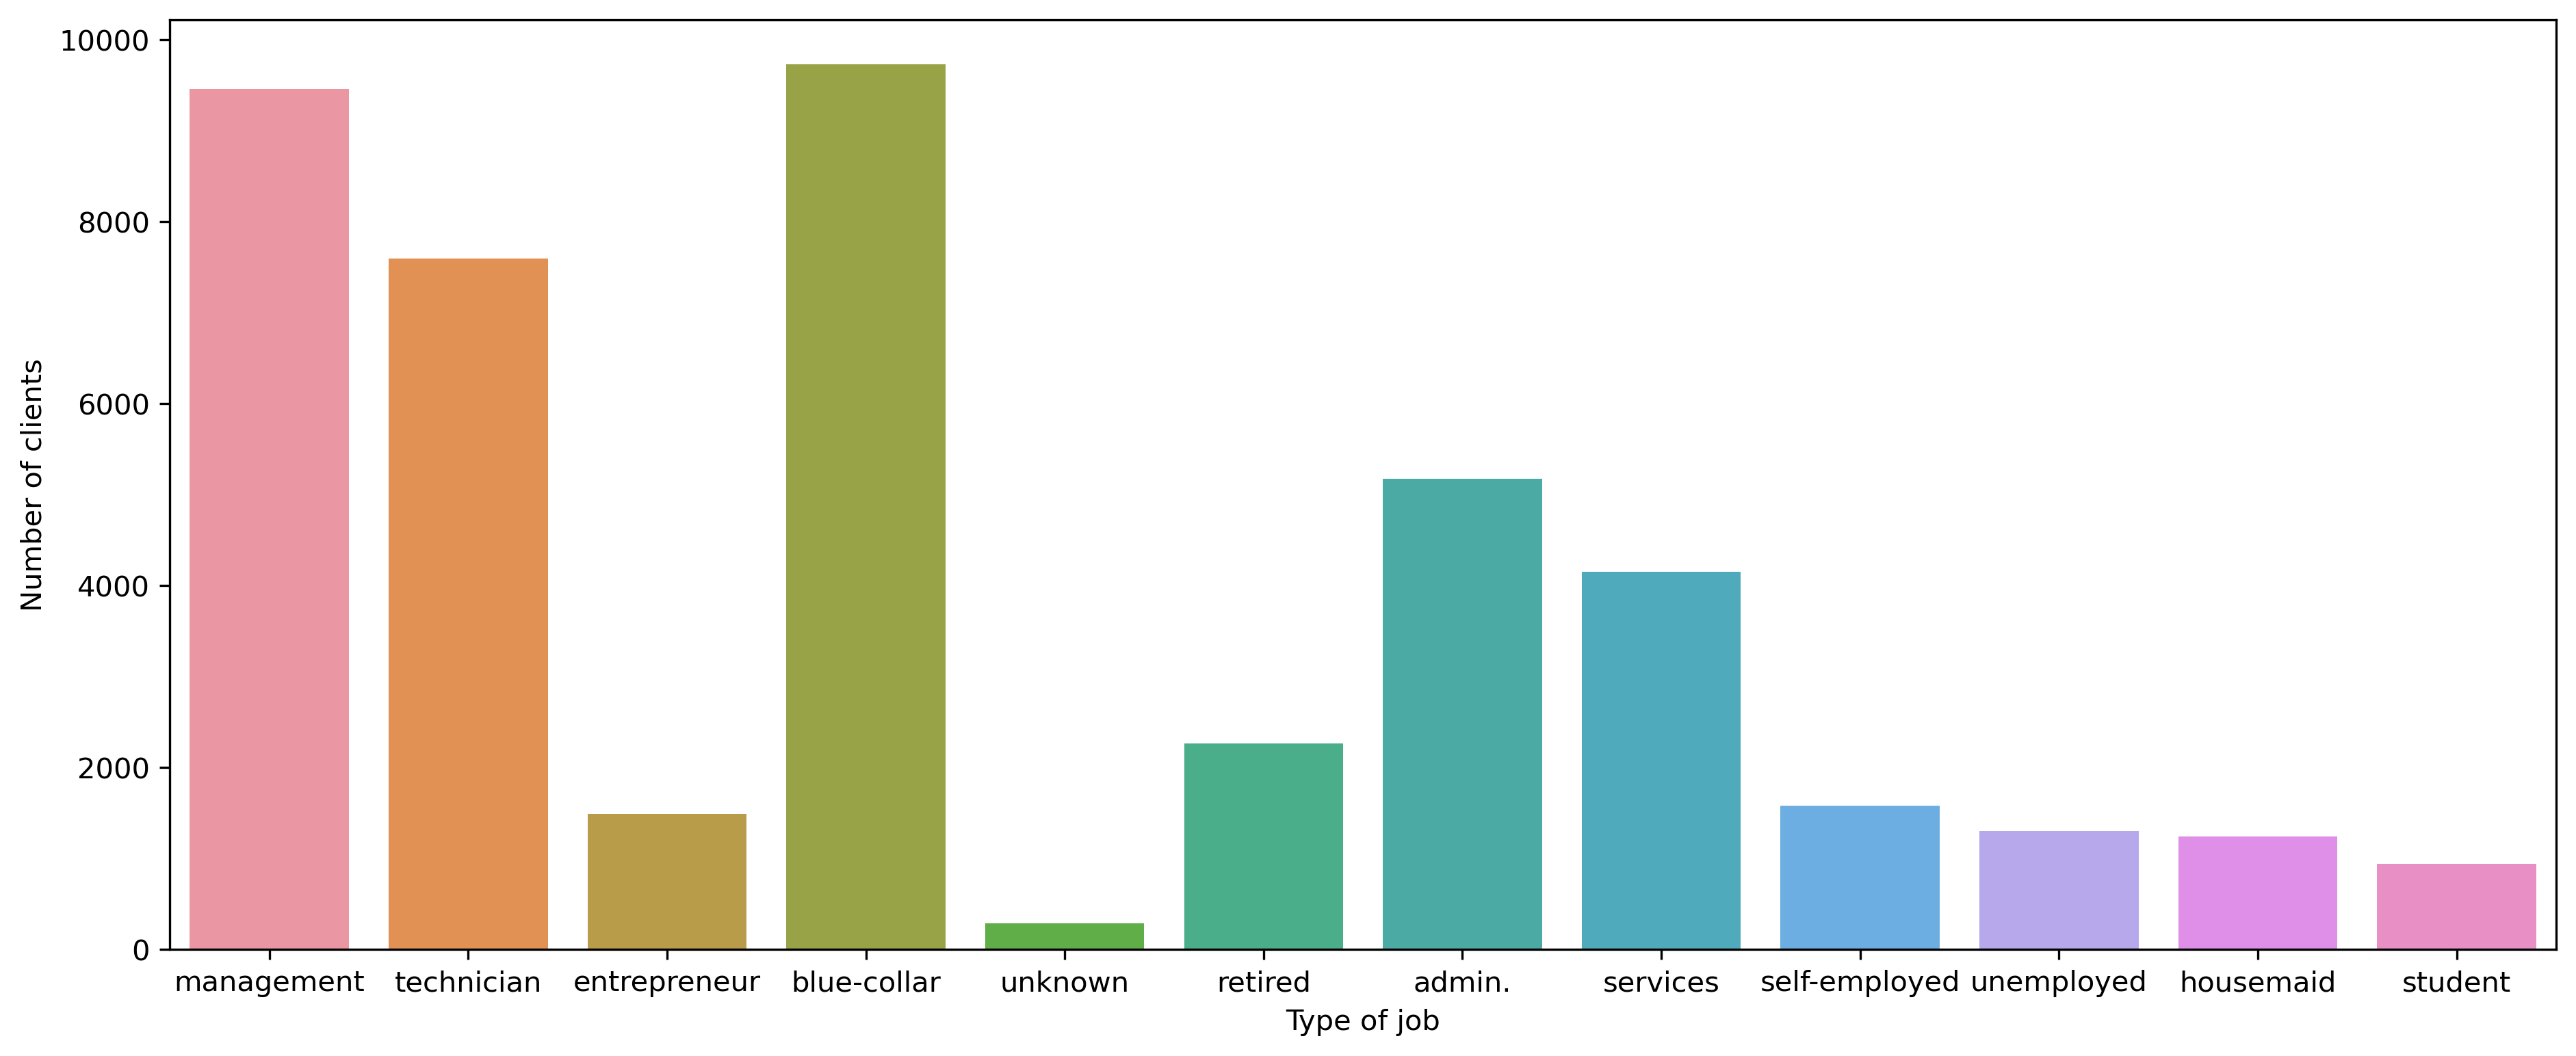

In [14]:
# Counterplot corresponding to job column
sns.countplot(x='job', data=data, figure=plt.figure(figsize=(15,6), dpi=300))
plt.xlabel('Type of job')
plt.ylabel('Number of clients')
plt.show()

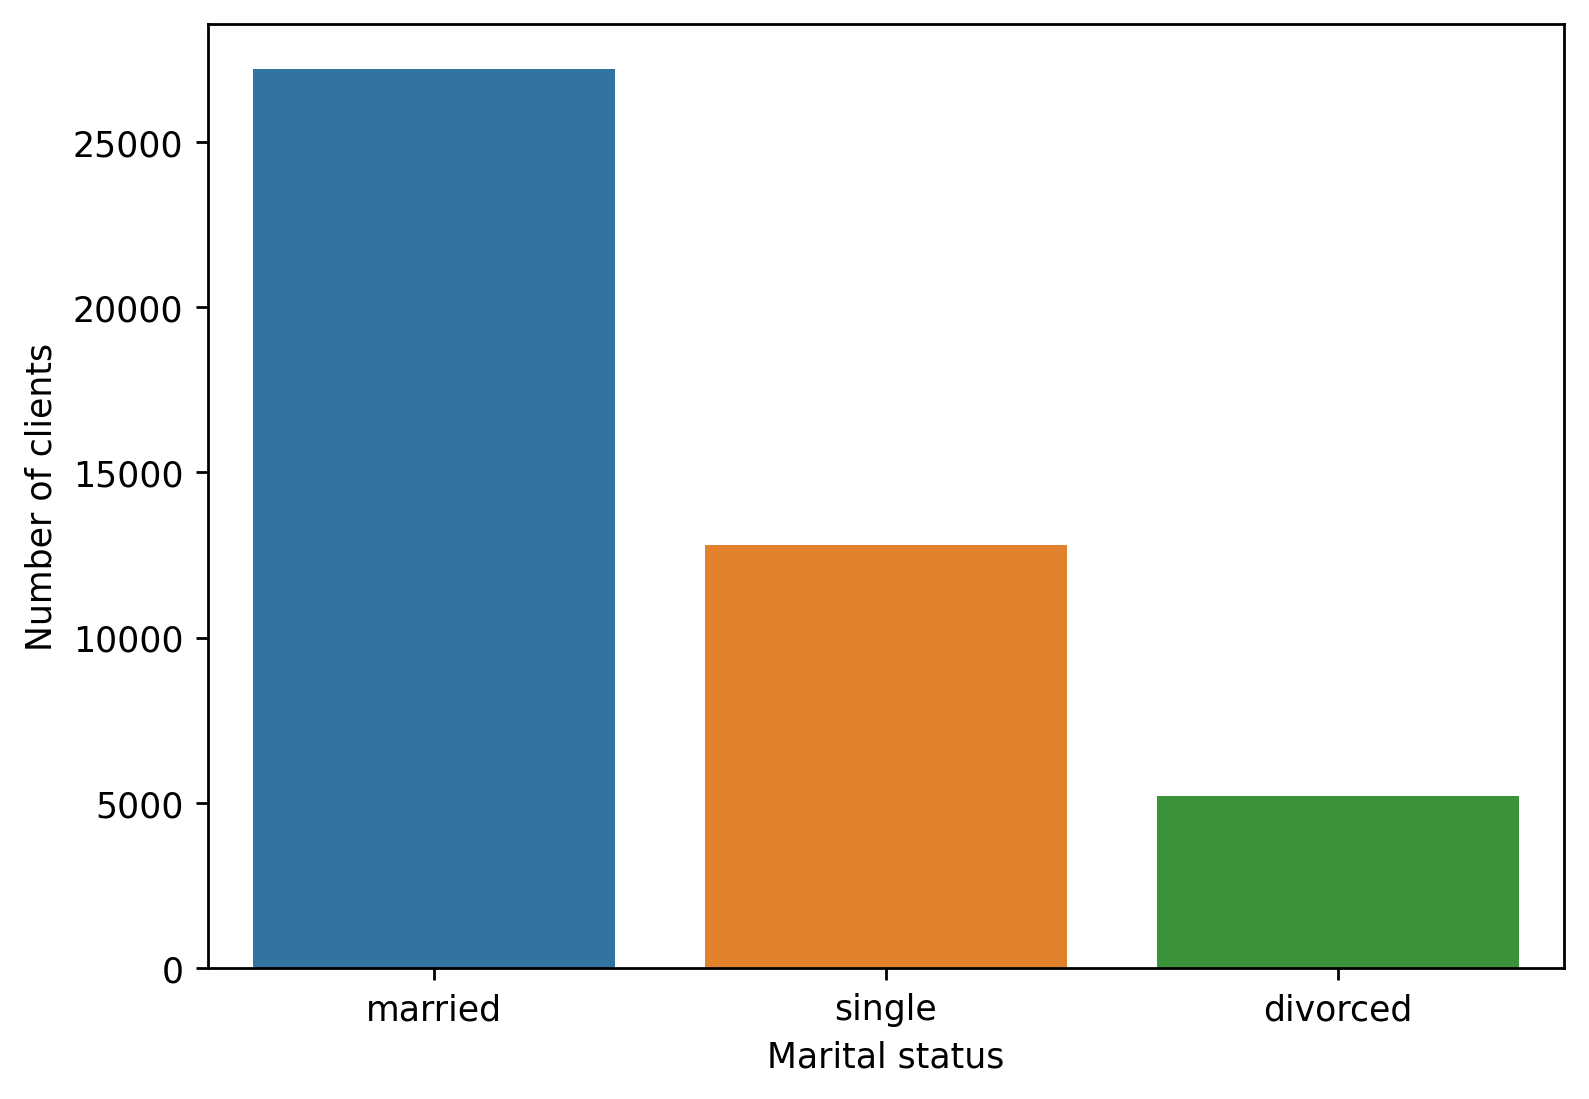

In [15]:
# Counterplot corresponding to marital column
sns.countplot(x='marital', data=data, figure=plt.figure(figsize=(7,5), dpi=250))
plt.xlabel('Marital status')
plt.ylabel('Number of clients')
plt.show()

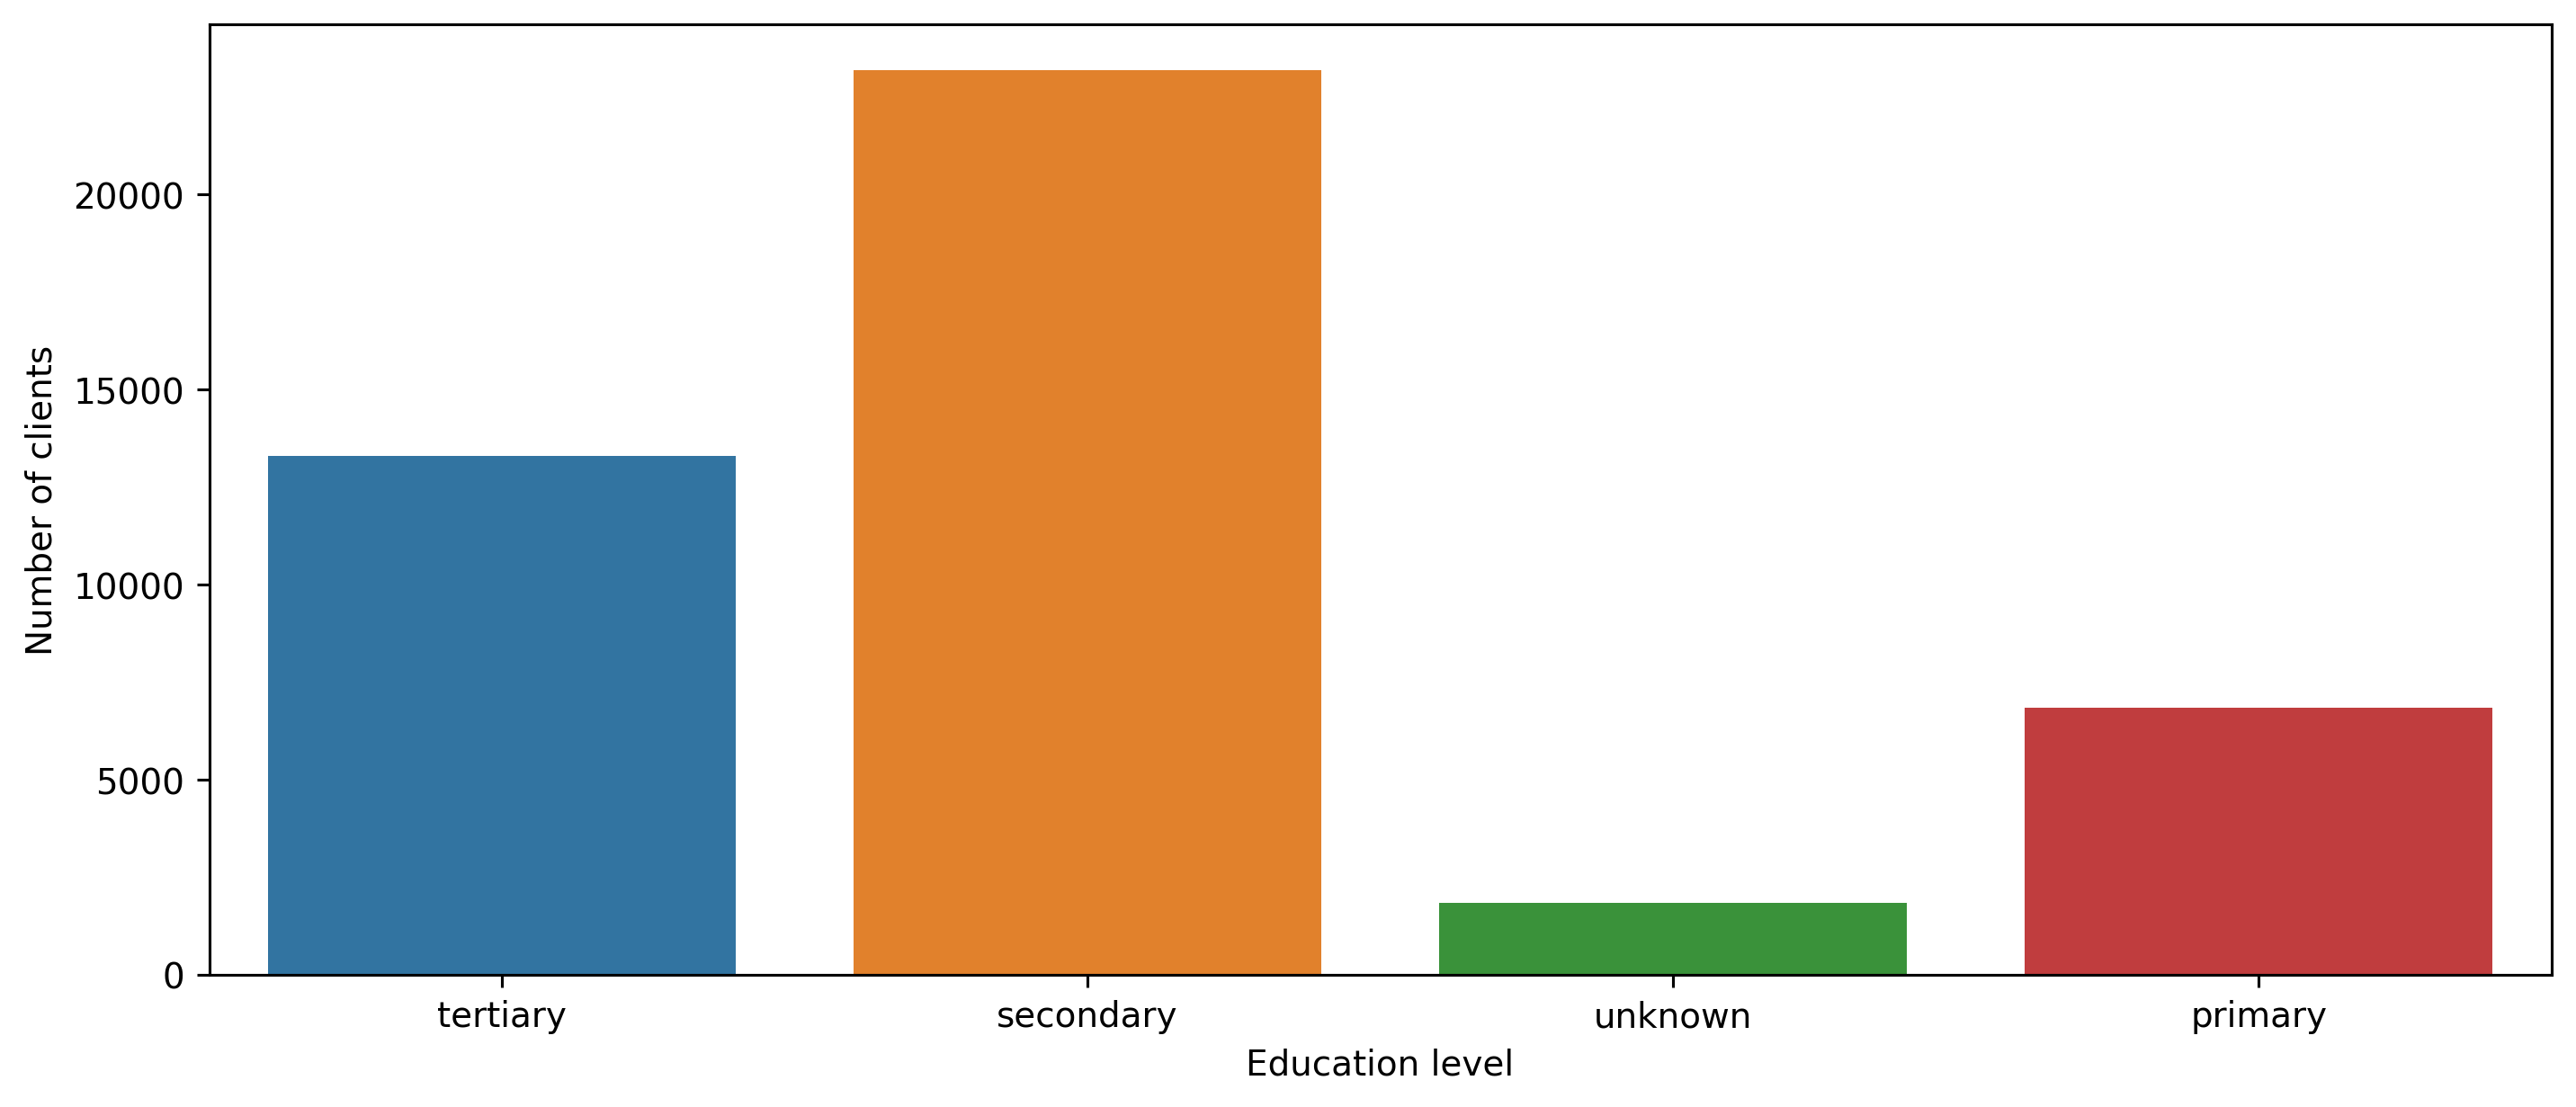

In [16]:
# Counterplot corresponding to education column
sns.countplot(x='education', data=data, figure=plt.figure(figsize=(12,5), dpi=280))
plt.xlabel('Education level')
plt.ylabel('Number of clients')
plt.show()

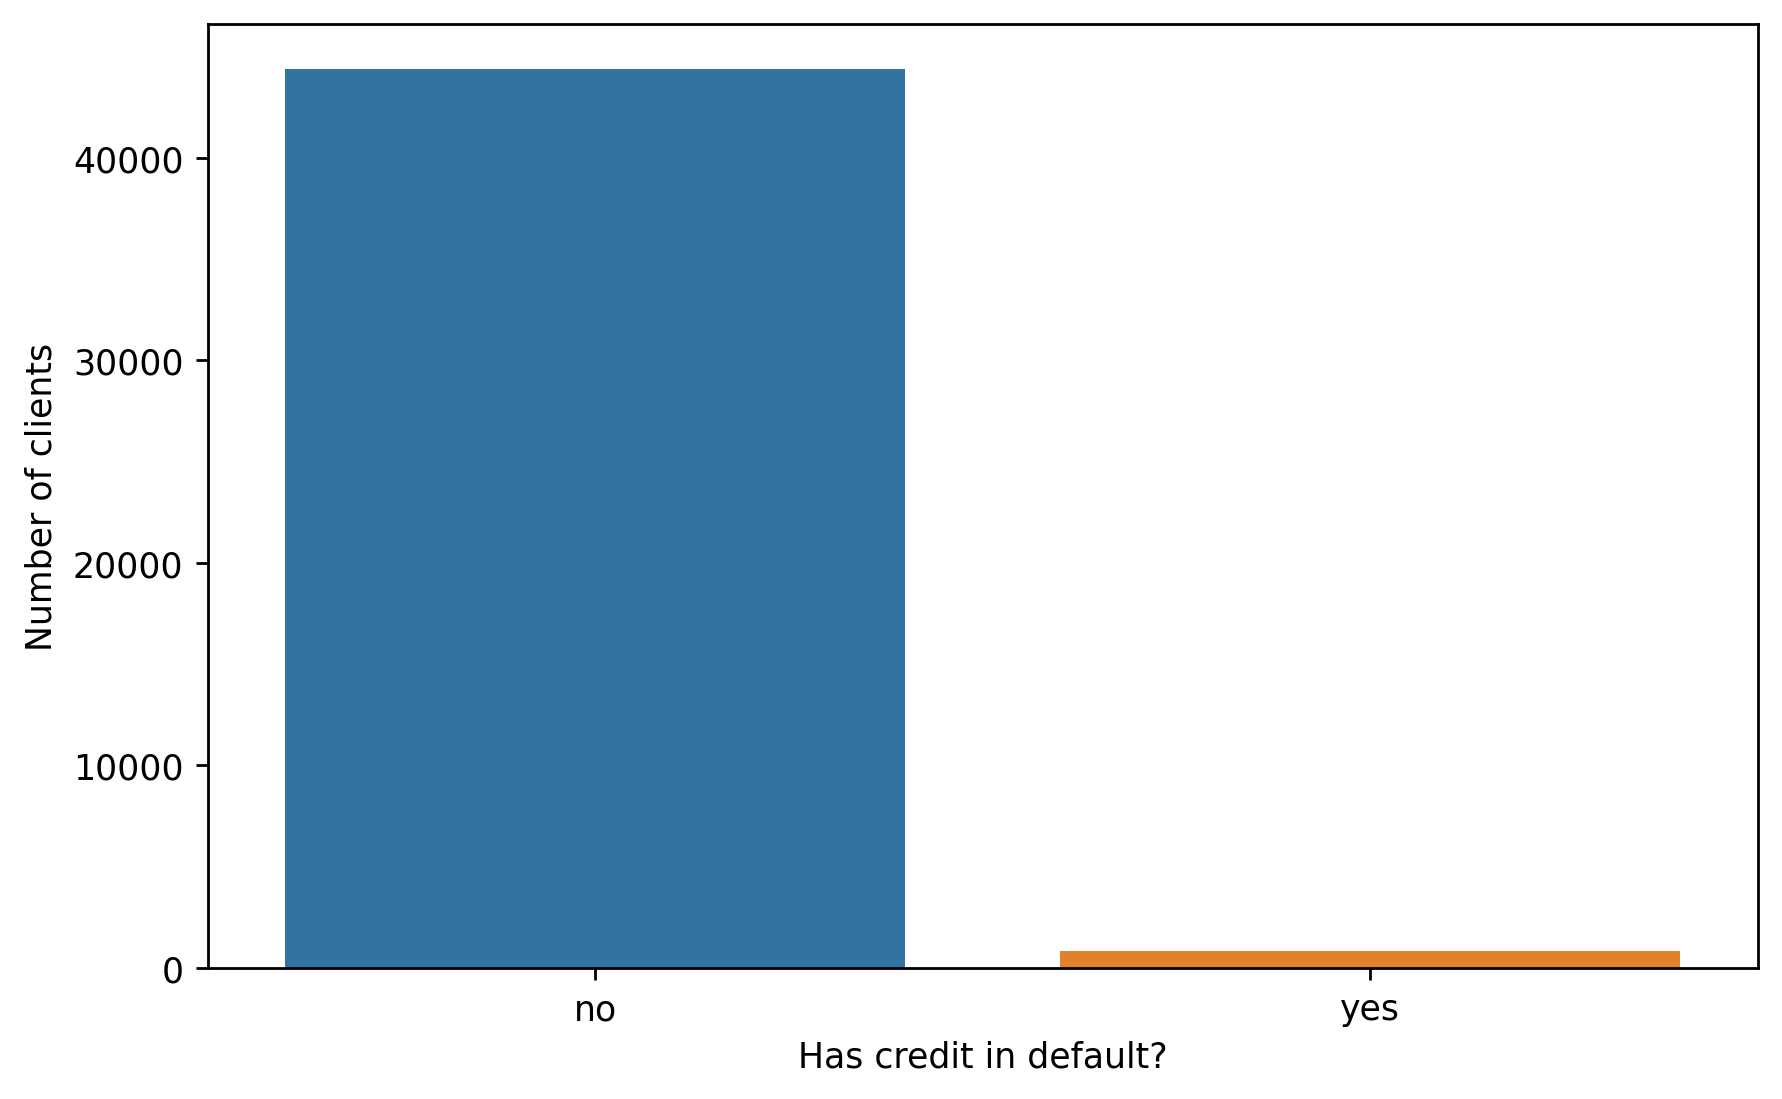

In [17]:
# Counterplot corresponding to default column
sns.countplot(x='default', data=data, figure=plt.figure(figsize=(8,5), dpi=250))
plt.xlabel('Has credit in default?')
plt.ylabel('Number of clients')
plt.show()

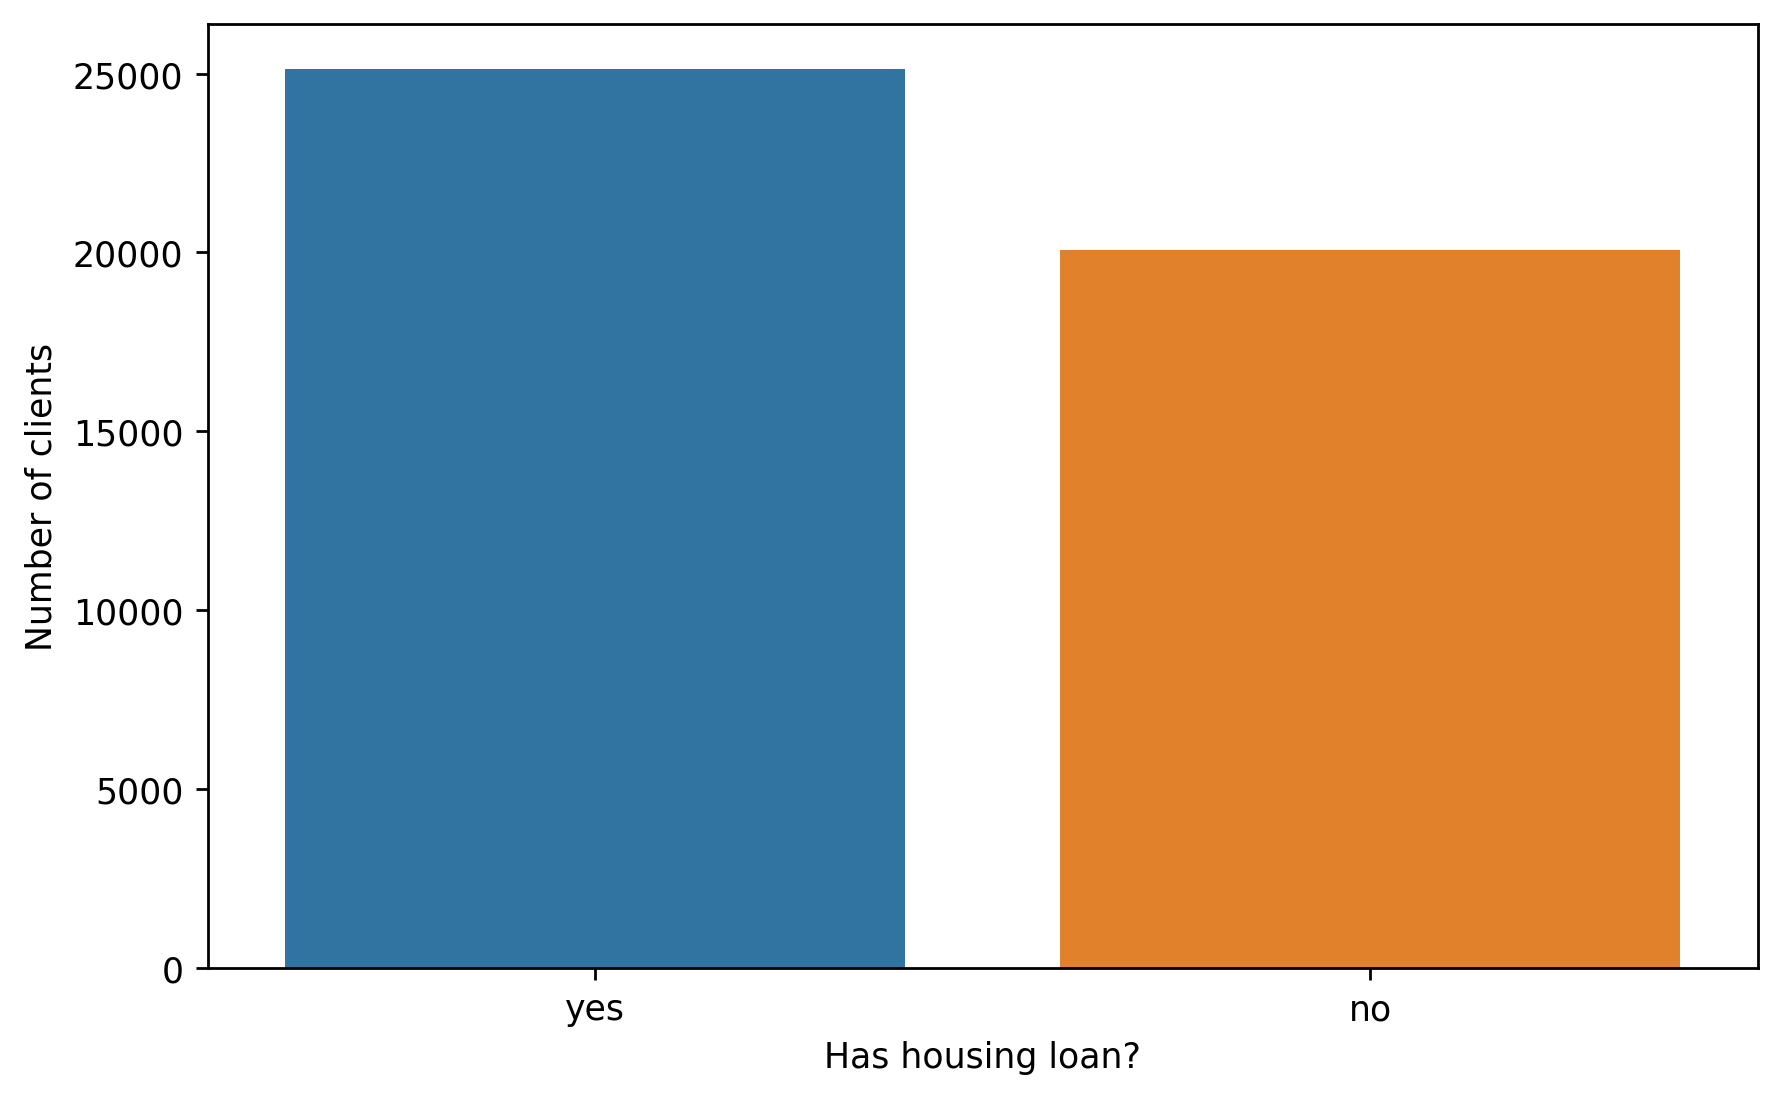

In [18]:
# Counterplot corresponding to housing column
sns.countplot(x='housing', data=data, figure=plt.figure(figsize=(8,5), dpi=250))
plt.xlabel('Has housing loan?')
plt.ylabel('Number of clients')
plt.show()

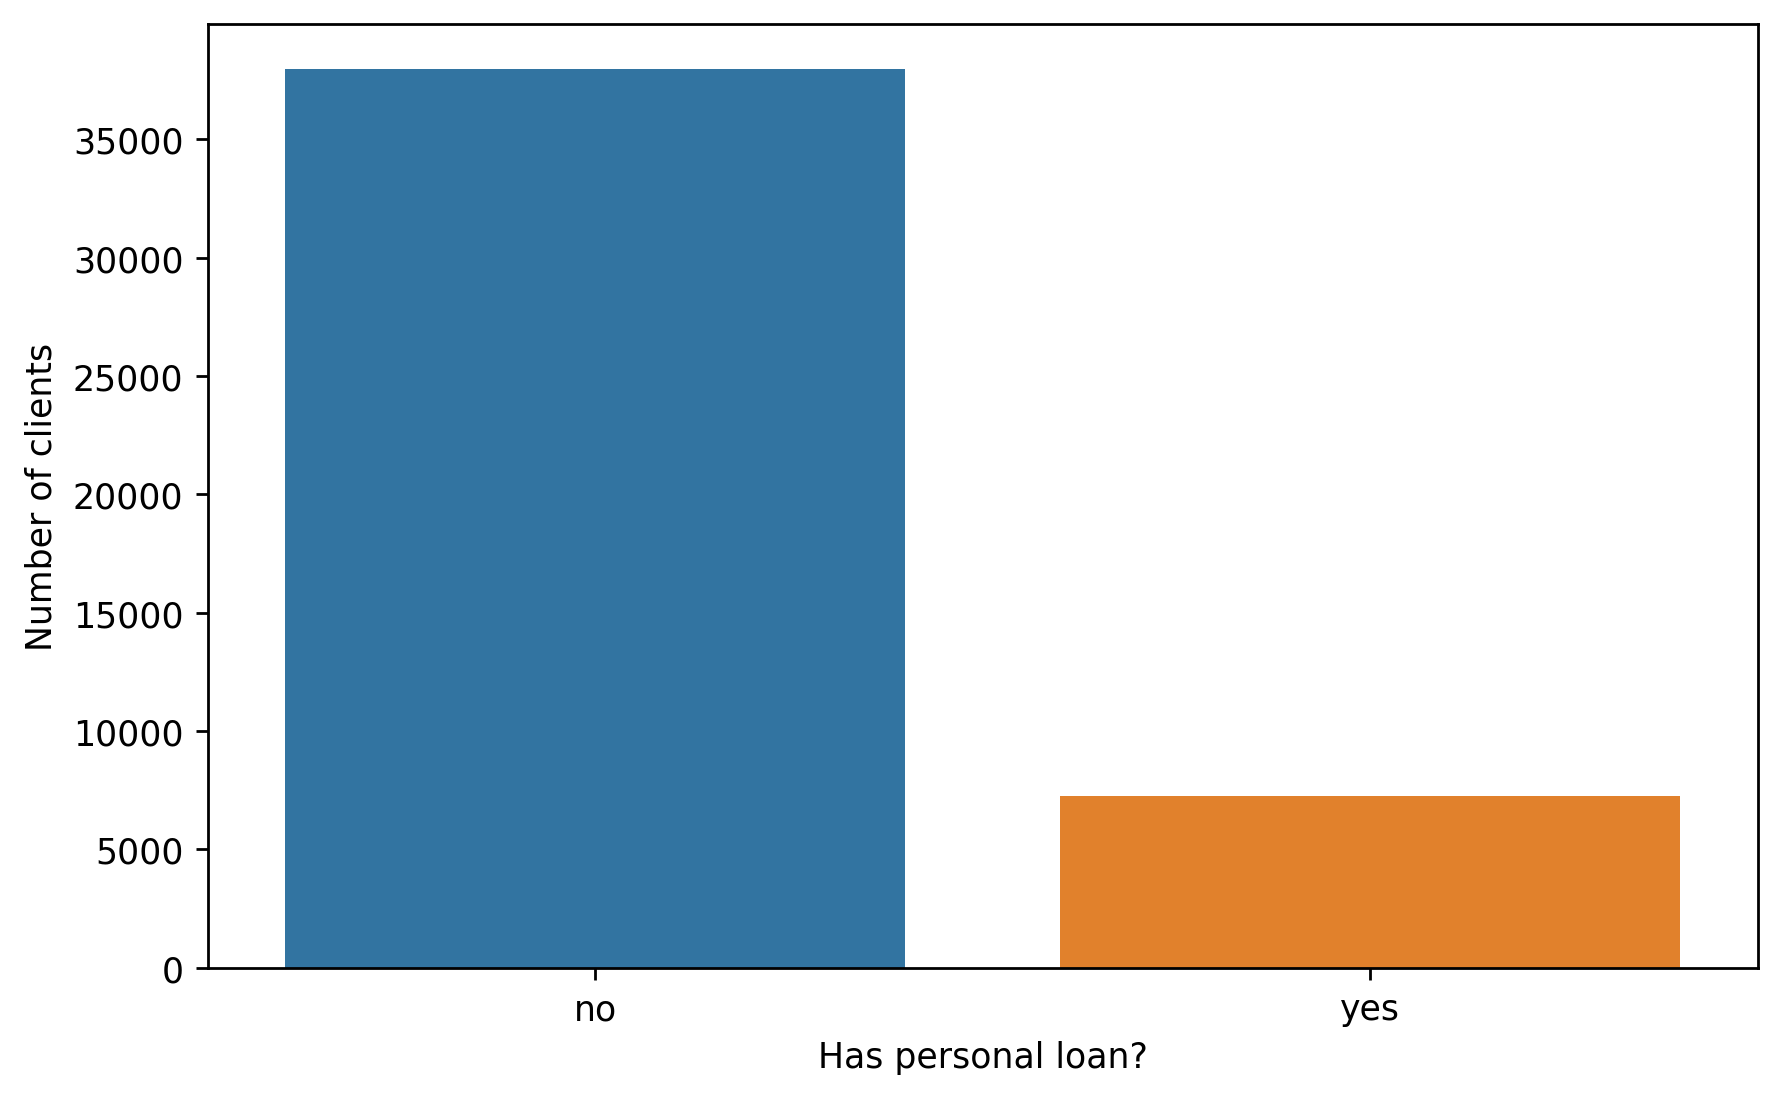

In [19]:
# Counterplot corresponding to loan column
sns.countplot(x='loan', data=data, figure=plt.figure(figsize=(8,5), dpi=250))
plt.xlabel('Has personal loan?')
plt.ylabel('Number of clients')
plt.show()

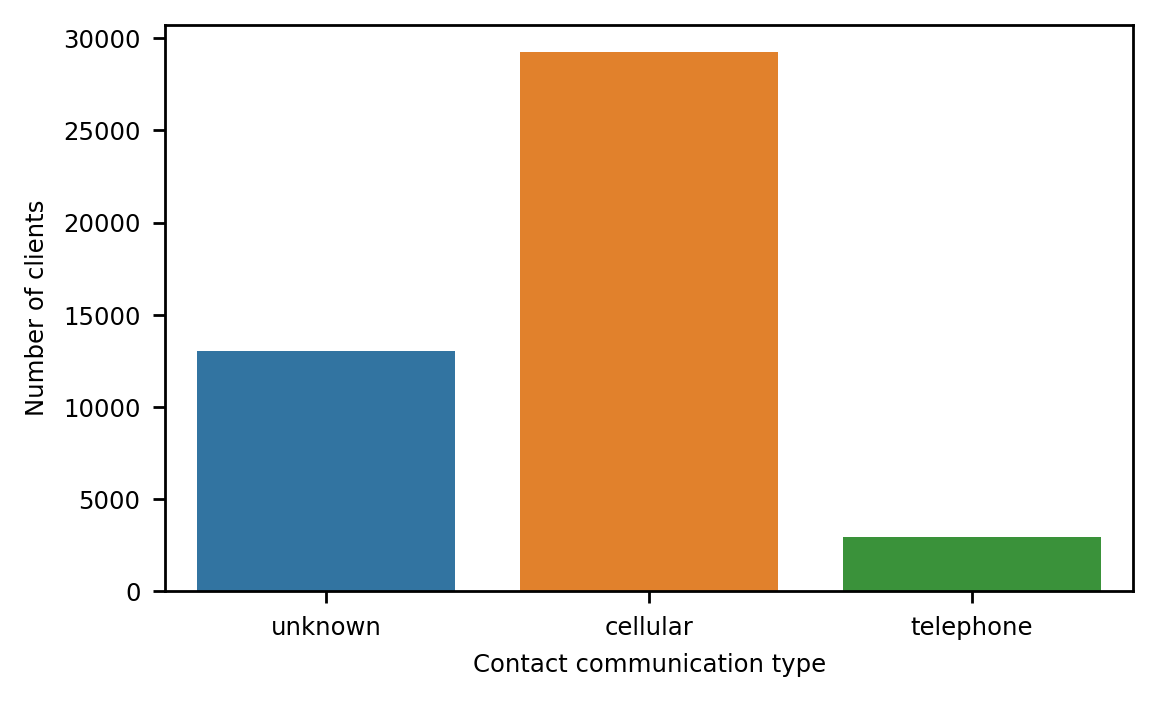

In [20]:
# Counterplot corresponding to contact column
sns.countplot(x='contact', data=data, figure=plt.figure(figsize=(5,3), dpi=250))
plt.xlabel('Contact communication type', fontsize=7)
plt.ylabel('Number of clients', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

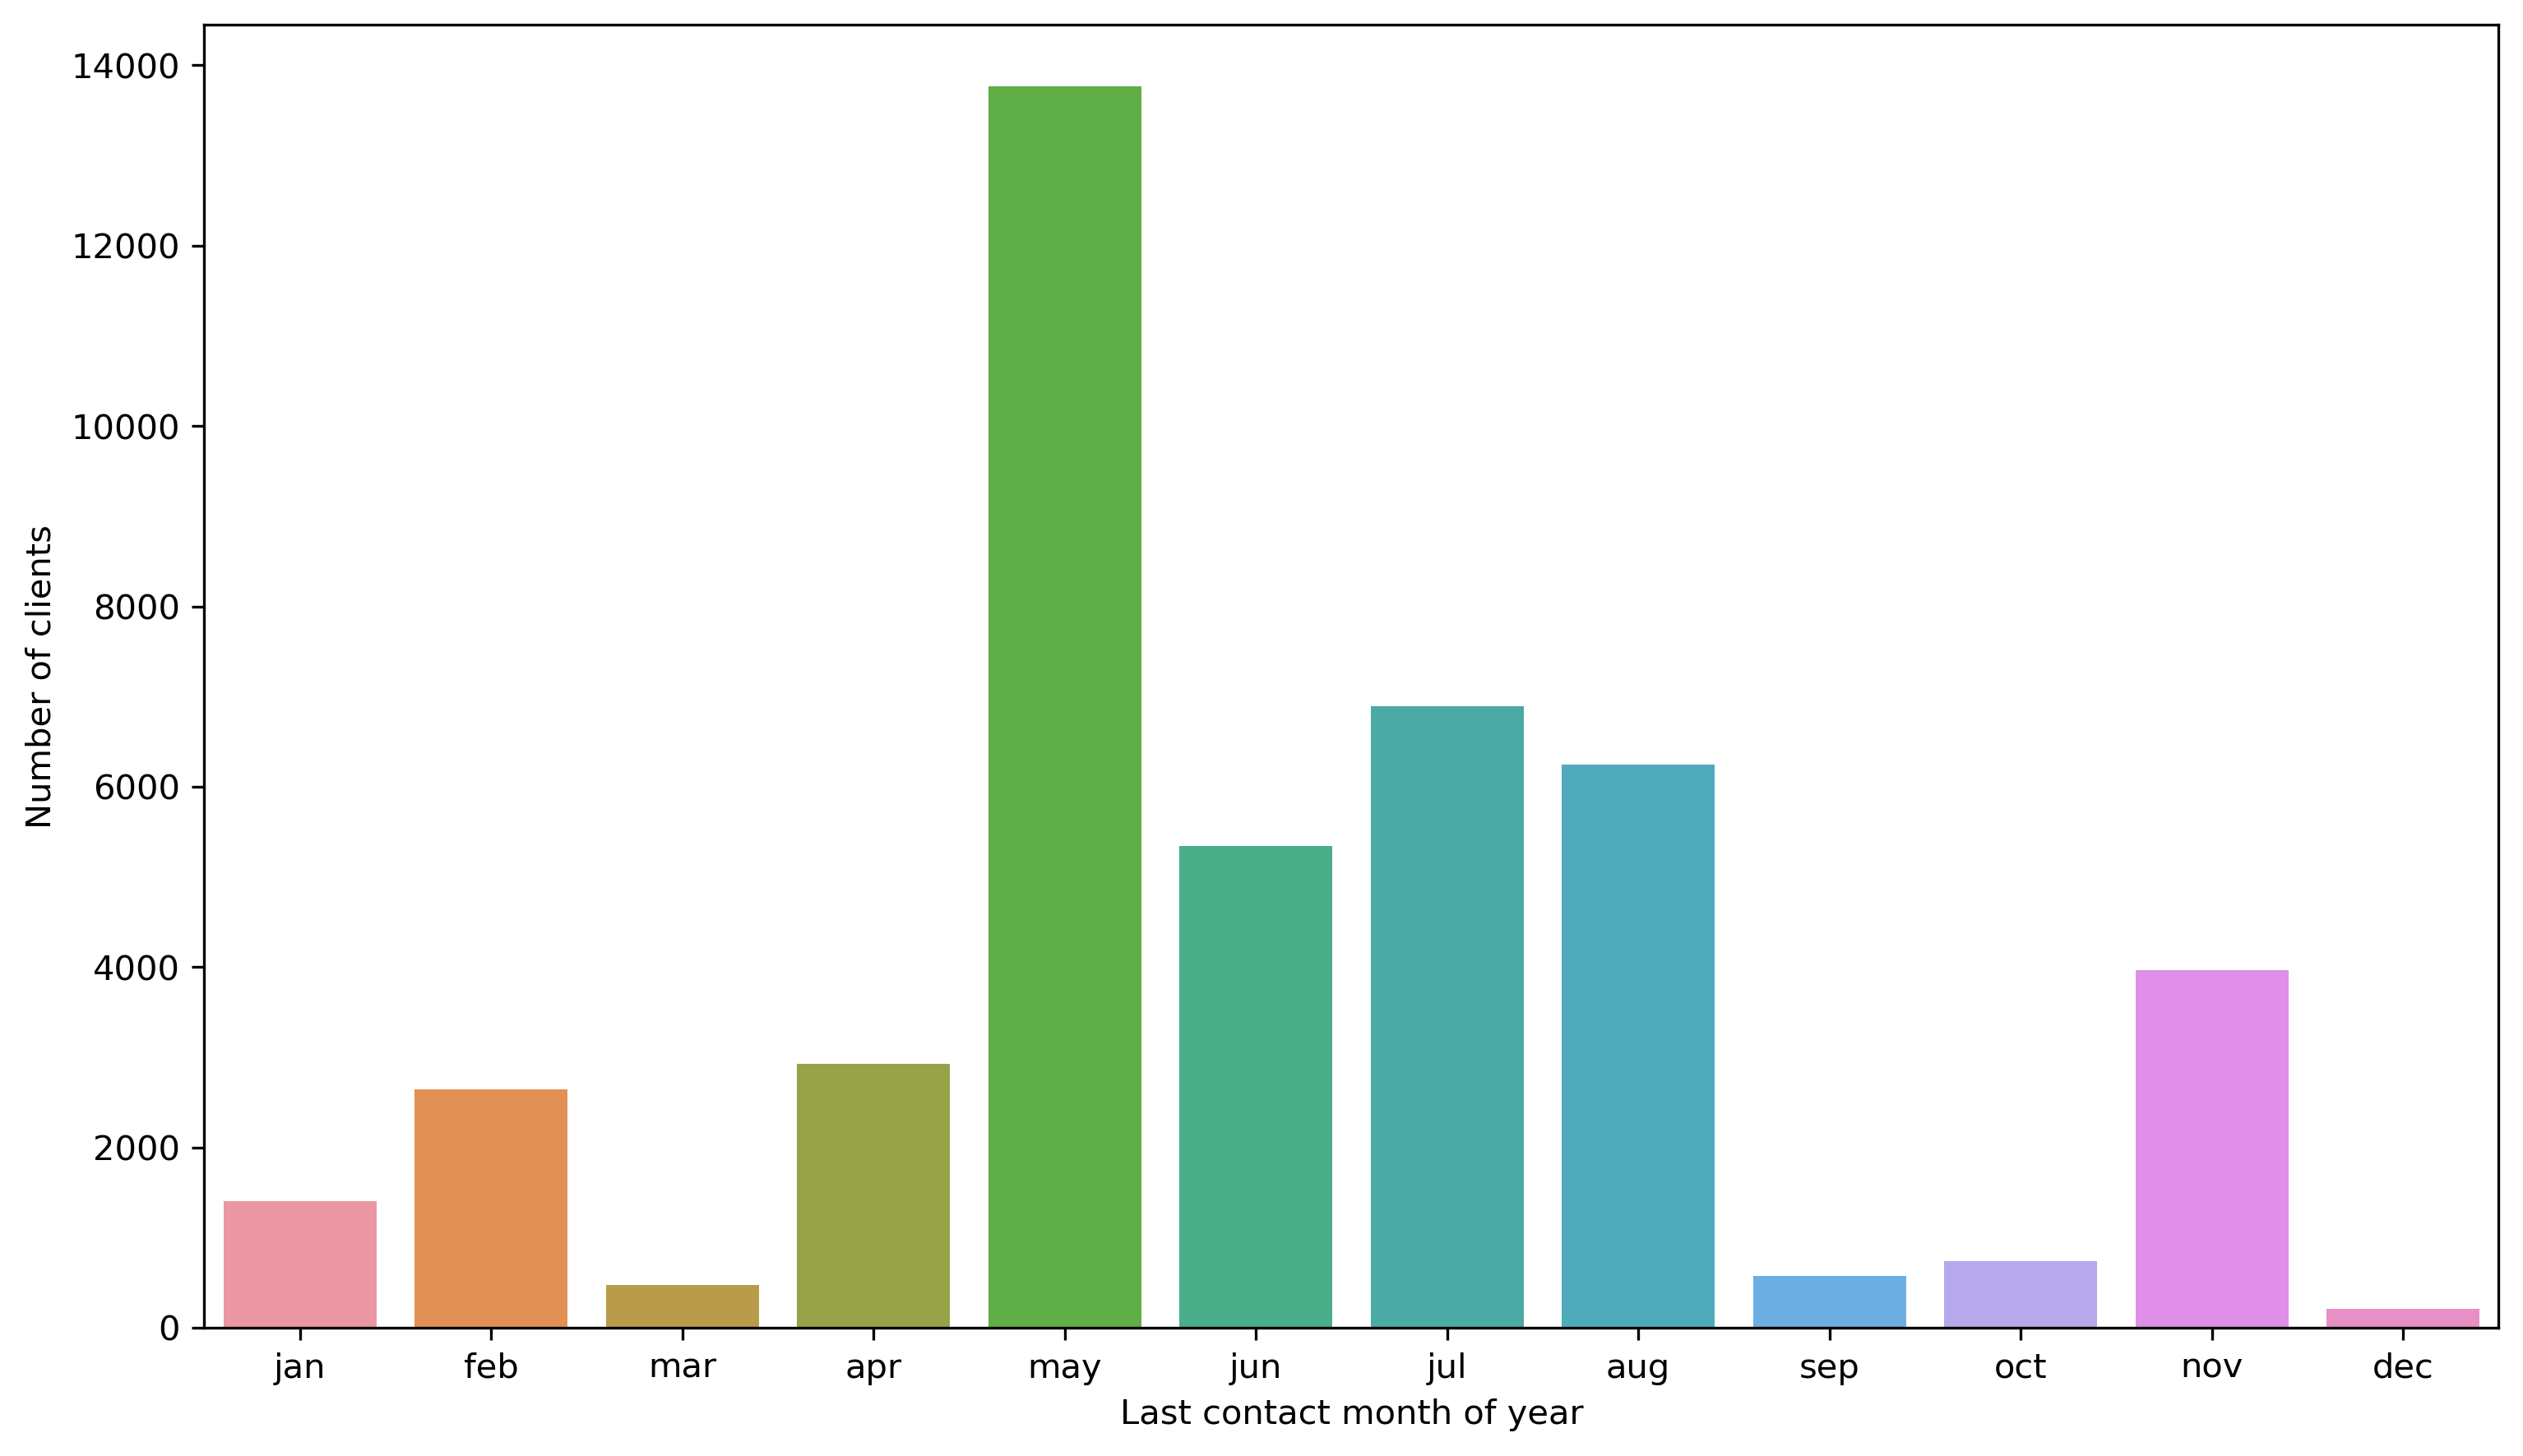

In [21]:
# Counterplot corresponding to month column
sns.countplot(x='month', data=data, order=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], figure=plt.figure(figsize=(12,7), dpi=300))
plt.xlabel('Last contact month of year')
plt.ylabel('Number of clients')
plt.show()

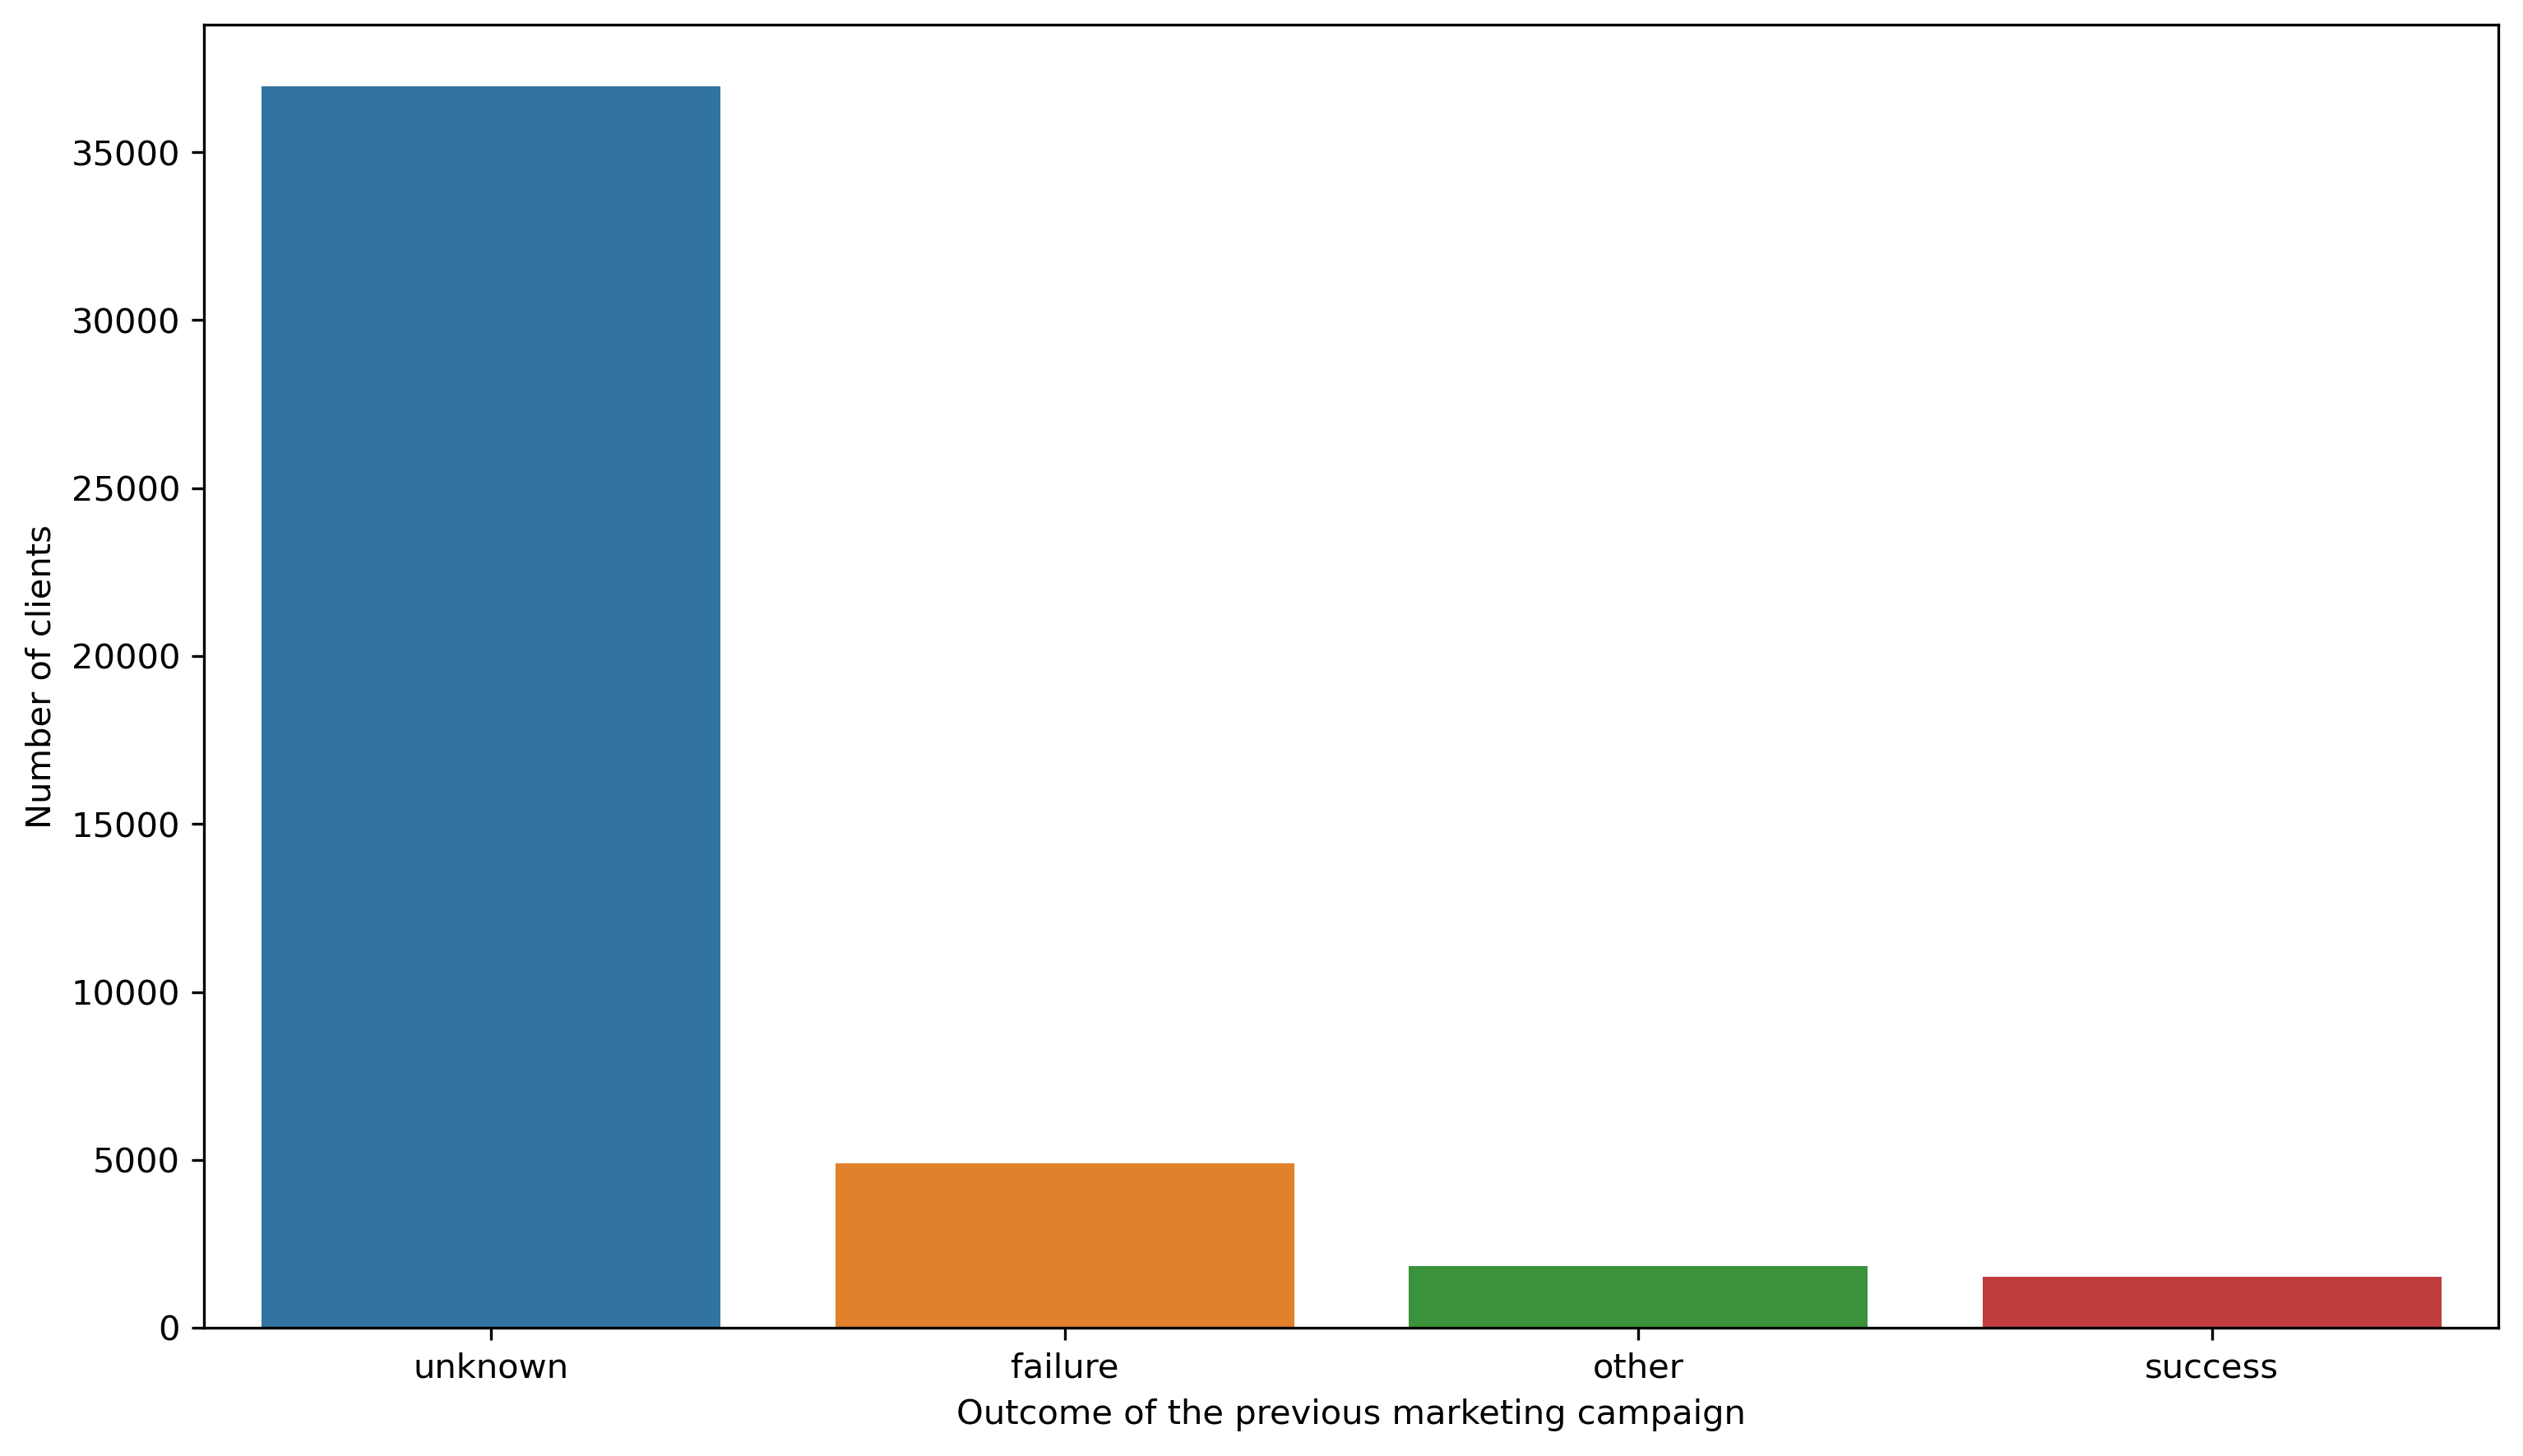

In [22]:
# Counterplot corresponding to poutcome column
sns.countplot(x='poutcome', data=data, figure=plt.figure(figsize=(12,7), dpi=300))
plt.xlabel('Outcome of the previous marketing campaign')
plt.ylabel('Number of clients')
plt.show()

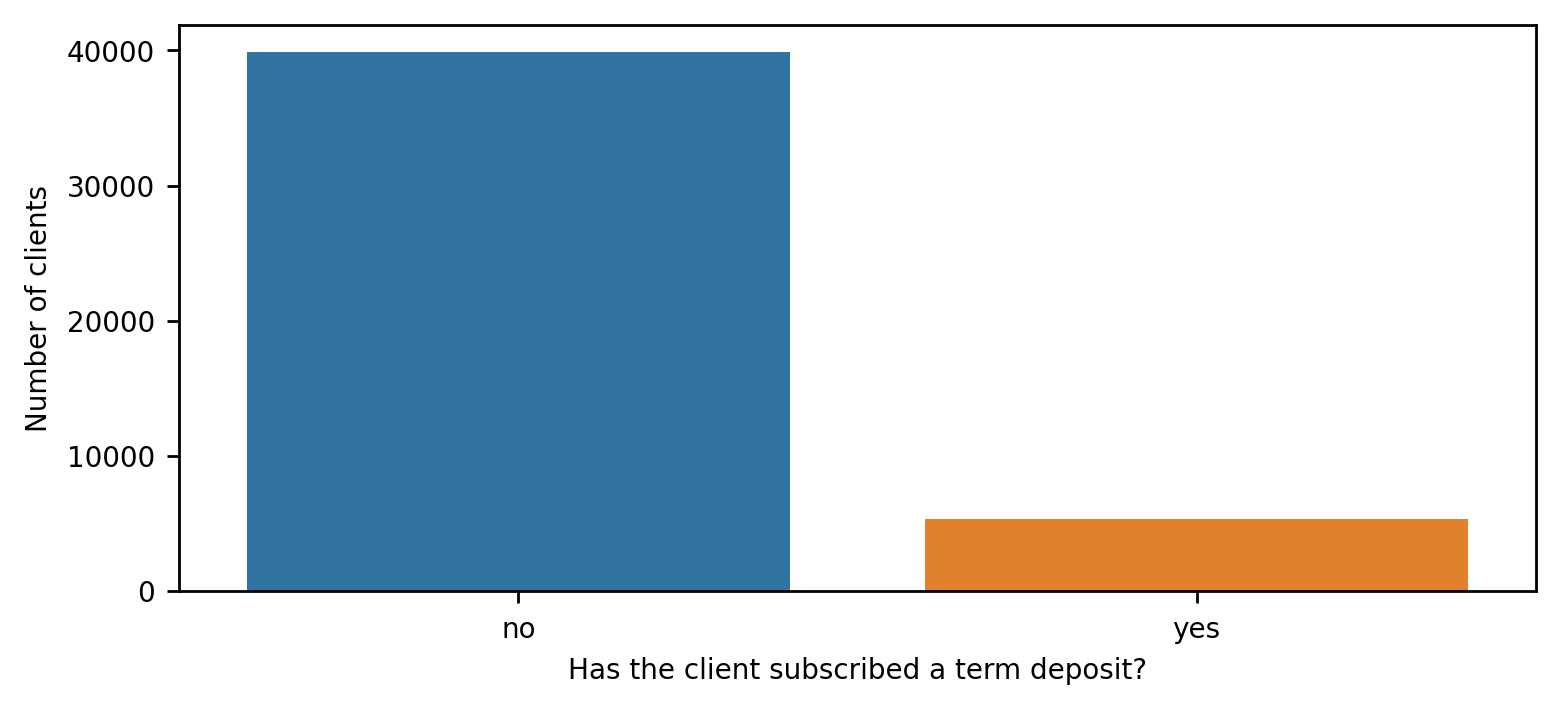

In [23]:
# Counterplot corresponding to y column
sns.countplot(x='y', data=data, figure=plt.figure(figsize=(7,3), dpi=250))
plt.xlabel('Has the client subscribed a term deposit?', fontsize=8)
plt.ylabel('Number of clients', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

Now, we are ready to make some component analysis of the dataset since it is needed to give the prediction model the correct inputs. This will be done through the Prince Python 3 package, wich you can find [here](https://github.com/MaxHalford/prince). Since we have a dataset with categorical and numerical features, it is needed to do a Factor Analysis of Mixed Data (FAMD), which is provided in Prince. After fit the dataset to the FAMD object, we need to check the cumulative contribution of each component to the total inertia. Recall that the total inertia is the sum of all the eigenvalues.

In [24]:
# Let us get the intputs and the targets
X, y = data.drop(["y"], axis=1), data["y"]

# Let us check the best number of principal components to use
famd = prince.FAMD(n_components=16, copy=True, check_input=True, random_state=10, engine='auto')

# We must fit the X data
famd = famd.fit(X)

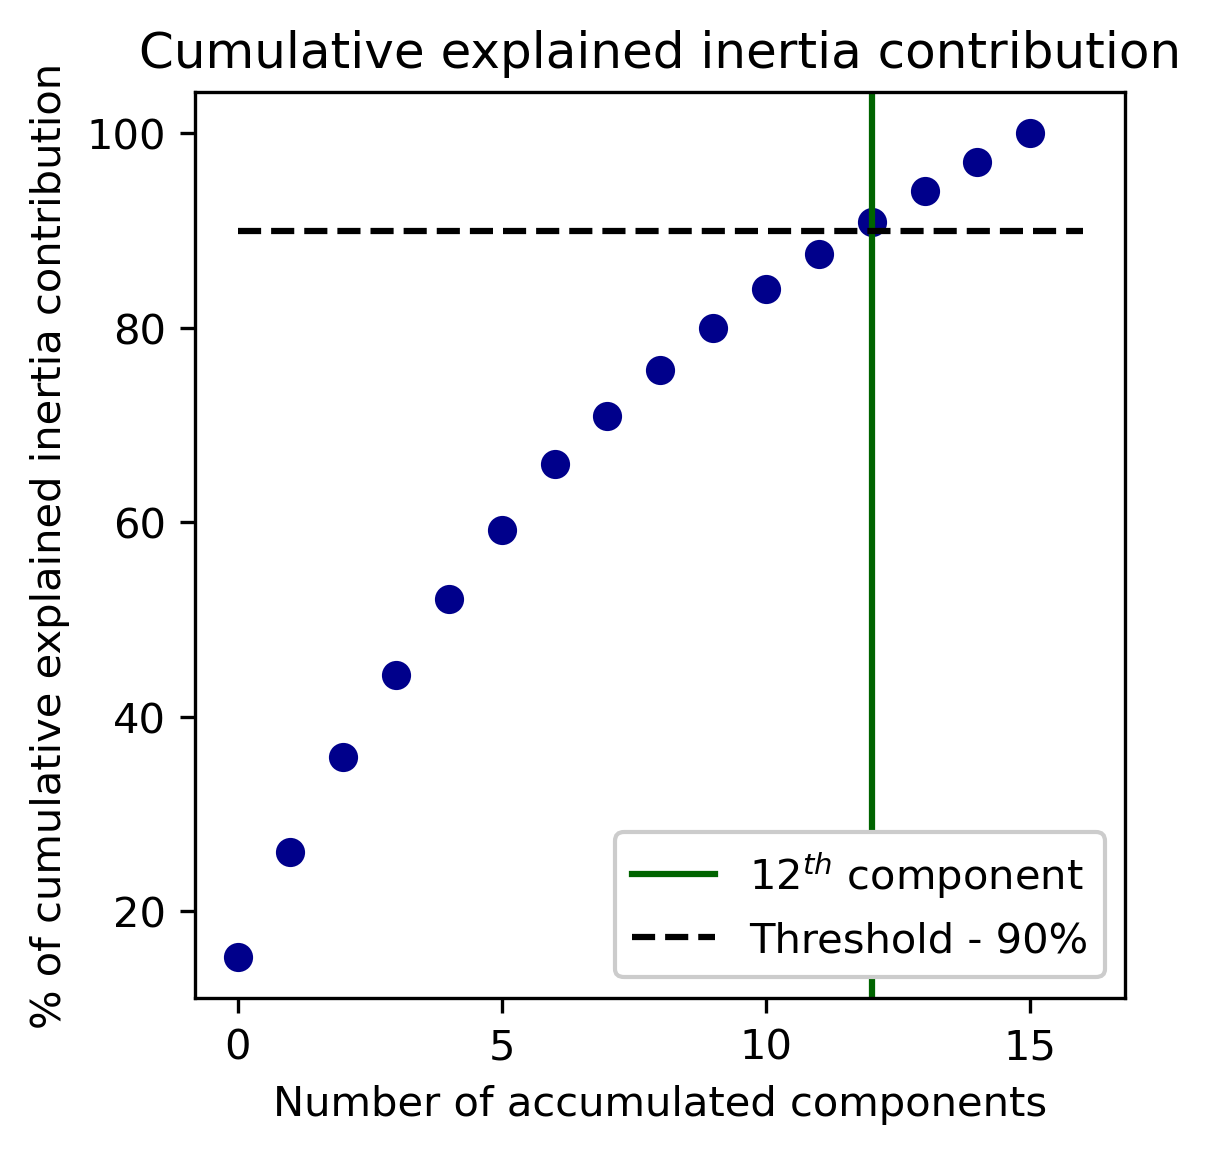

In [25]:
# Let us get the eigenvalues in increasing order
eig = famd.eigenvalues_

# We define the total inertia
tot_in = np.sum(eig)

# We define the explained inertia for each component
exp_in = eig/tot_in

# Let us create the cumulative explained inertia contribution array
cumulative = []
for i in range(len(exp_in)):
    cumulative.append(np.sum(exp_in[:i+1]))
    
cumulative = np.array(cumulative)
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
ax.axvline(x=12, color='darkgreen', label=r'$12^{th}$ component')
ax.scatter(np.arange(0, len(cumulative), 1), 100*cumulative, color='darkblue')
ax.plot(np.linspace(0, 16, 100), 90*np.ones(100), ls='--', color='black', label=r'Threshold - 90%')
ax.set_xlabel('Number of accumulated components')
ax.set_ylabel(r'% of cumulative explained inertia contribution')
ax.set_title('Cumulative explained inertia contribution')
plt.legend(loc='lower right', framealpha=1)
plt.show()

We can see in the plot above that the component from where the cumulative explained inertia is above the threshold is component number twelve. So, based on this result, we can fit a FAMD defined with twelve components to the data. This way, we will reduce the number of dimensions from 16 to 12. Let us work on that.

In [26]:
# Let us instantiate a FAMD object with 12 components
famd = prince.FAMD(n_components=12, copy=True, check_input=True, random_state=11, engine='auto')

# We must fit the X data
famd = famd.fit(X)

# Let us transform the dataset so we get the principal components
X_t = famd.transform(X)

Now we have transformed the dataset and saved it on X_t we can check its statistical properties.

In [27]:
X_t.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04
mean,-2.867922e-15,-4.684370e-16,-5.486090e-16,-1.183917e-16,9.069107e-17,3.930473e-16,6.930121e-16,3.723597e-16,6.145873e-16,2.630785e-16,2.209101e-17,2.297688e-16
std,1.124189e+00,9.448953e-01,8.981163e-01,8.347839e-01,8.071380e-01,7.661075e-01,7.458580e-01,6.421855e-01,6.228466e-01,5.985890e-01,5.722069e-01,5.370967e-01
min,-3.288906e+00,-2.260021e+00,-5.178002e+00,-4.275536e+00,-8.363800e+00,-1.727409e+00,-2.004051e+00,-2.787872e+00,-2.282915e+00,-3.345733e+00,-1.852376e+00,-3.320610e+00
25%,-5.773811e-01,-6.713144e-01,-6.117123e-01,-5.367885e-01,-4.076600e-01,-4.951329e-01,-5.576650e-01,-2.755637e-01,-4.444601e-01,-3.358344e-01,-3.665952e-01,-3.276376e-01
50%,-3.825346e-01,-1.414541e-01,-4.742869e-02,-1.030579e-01,1.598112e-02,-9.142766e-02,-1.416154e-02,-4.414187e-03,5.466862e-02,-2.426635e-02,-5.334468e-02,8.076394e-02
75%,-1.354095e-01,5.392908e-01,4.960787e-01,3.927663e-01,4.207881e-01,3.425440e-01,5.280506e-01,2.996297e-01,4.568404e-01,3.446117e-01,2.875963e-01,3.946350e-01
max,5.449749e+01,1.118577e+01,1.606524e+01,1.540688e+01,1.599612e+01,1.258015e+01,1.048531e+01,6.654810e+01,1.950206e+01,2.493482e+01,5.041416e+00,9.260877e+00


We can plot the correlation matrix of the transformed dataset in addition with the output column. But before, it is better to do a label encoding over the output variable.

In [28]:
# We create a LabelEnconder object
encoder = preprocessing.LabelEncoder()

# We overwrite the column of the categorical variable to convert it into numeric values
y = encoder.fit_transform(y)
    
# Let us print the new output variable
print(y)

# Identify which value is no and which one is yes
print(np.unique(y, return_counts=True))

[0 0 0 ... 1 0 0]
(array([0, 1]), array([39922,  5289]))


We can see that the $0$ corresponds to $no$ values and the $1$ to $yes$ values.

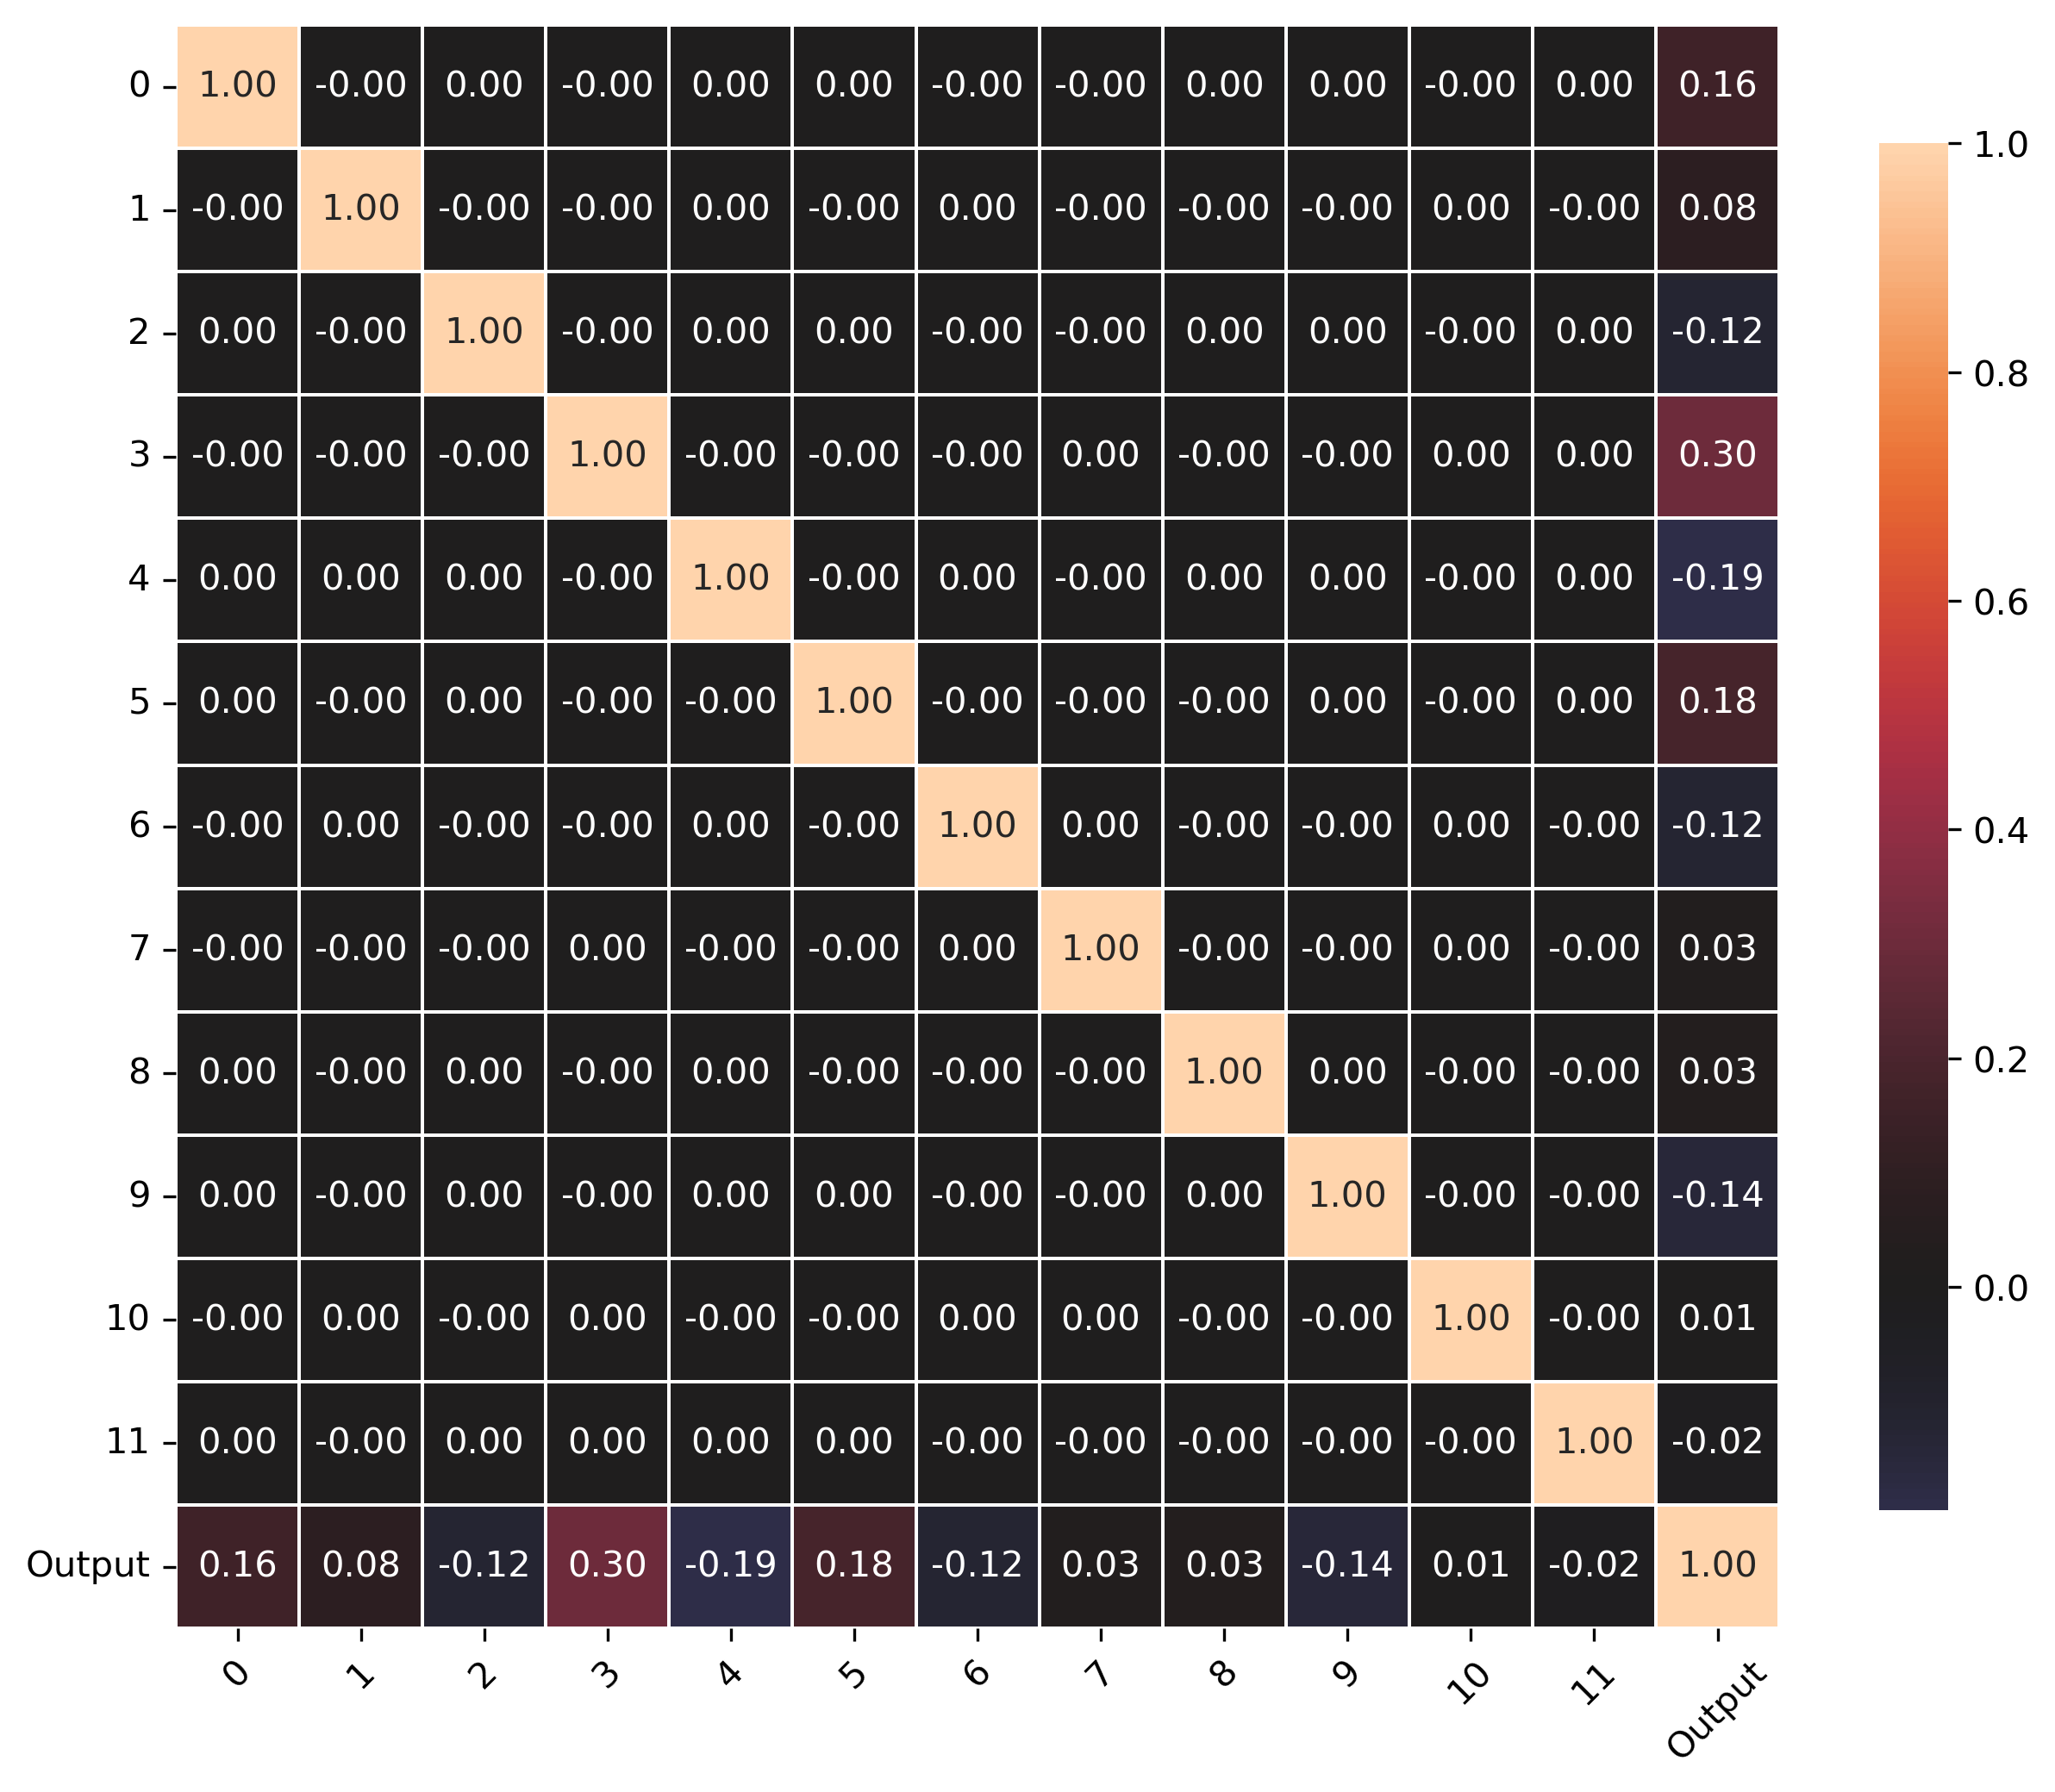

In [29]:
# Let us concatenate the transformed data in addition with the output variable
data_conc = pd.concat((X_t, pd.Series(y, name='Output')), axis=1)

# Plot of the correlation matrix
fig, ax = plt.subplots(figsize=(10,10), dpi=300)
sns.heatmap(data_conc.corr(), vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}, figure=fig)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Now we have decorrelated the input features in the dataset and that they are all continuous variables, we have to $balance$ the dataset, since, as seen in the counterplot corresponding to the output variable, it is highly imbalanced. We will make use of $\texttt{resample}$ from sklearn and $\texttt{SMOTE}$ from the imblearn libraries to balance the dataset in two different ways, since if we do so, we will be able to compare two different models.

In [30]:
# SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=30)

# Fit the model to generate the data
X_SMOTE, y_SMOTE = sm.fit_sample(X_t, y)

# We convert y_SMOTE in a pandas Dataframe object
y_SMOTE = pd.Series(y_SMOTE, name='Output')

# Let us concatenate the new dataframes
df_SMOTE = pd.concat((X_SMOTE, y_SMOTE), axis=1)

In [31]:
# Resample
# Create two different dataframe of majority and minority class 
df_majority = data_conc[(data_conc['Output'] == 0)]
df_minority = data_conc[(data_conc['Output'] == 1)]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,                 # sample with replacement
                                 n_samples=len(df_majority),   # to match majority class
                                 random_state=15)              # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

# Separete input data from output data
X_upsampled, y_upsampled = df_upsampled.drop(['Output'], axis=1), df_upsampled['Output']

Now, let us check the two new datasets.

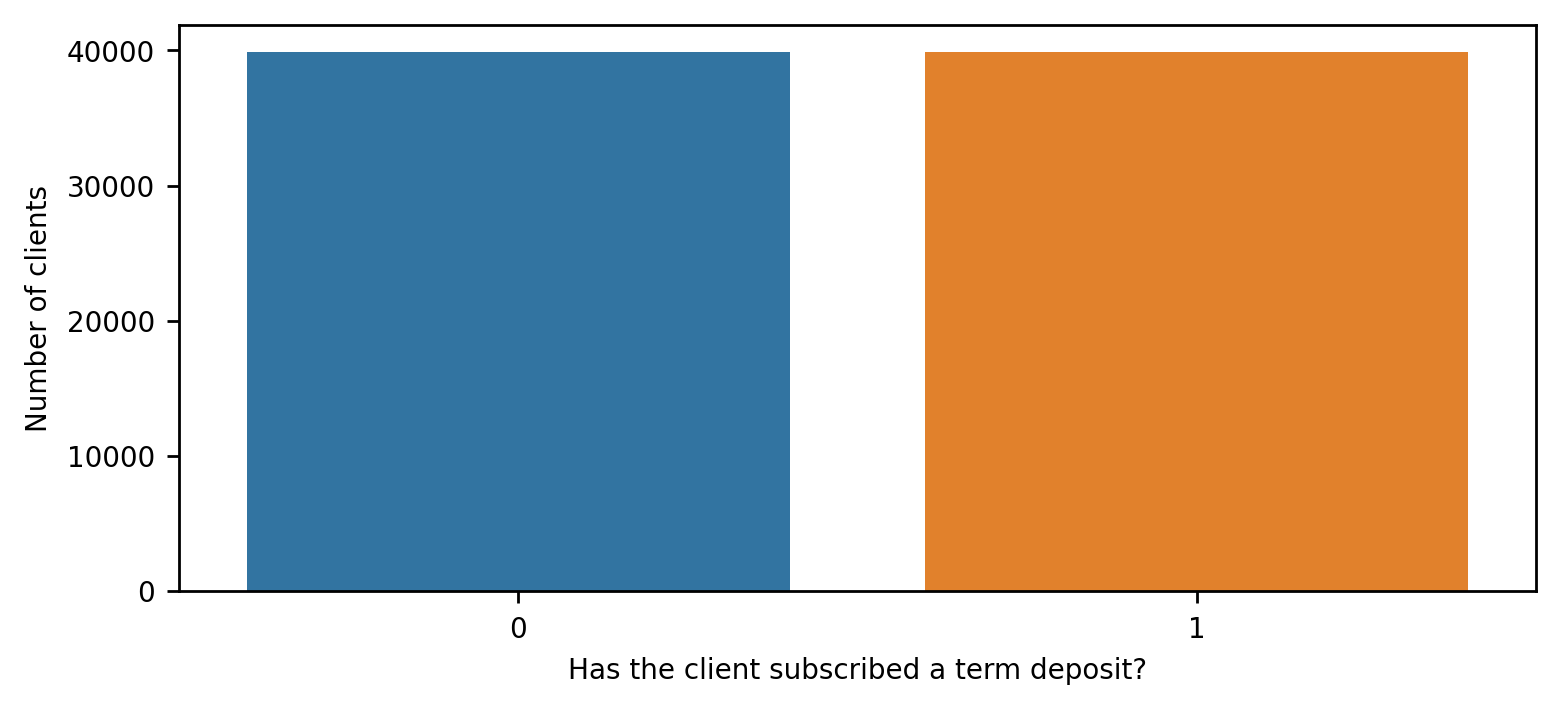

In [32]:
# Counterplot corresponding to y column of df_SMOTE
sns.countplot(x='Output', data=df_SMOTE, figure=plt.figure(figsize=(7,3), dpi=250))
plt.xlabel('Has the client subscribed a term deposit?', fontsize=8)
plt.ylabel('Number of clients', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

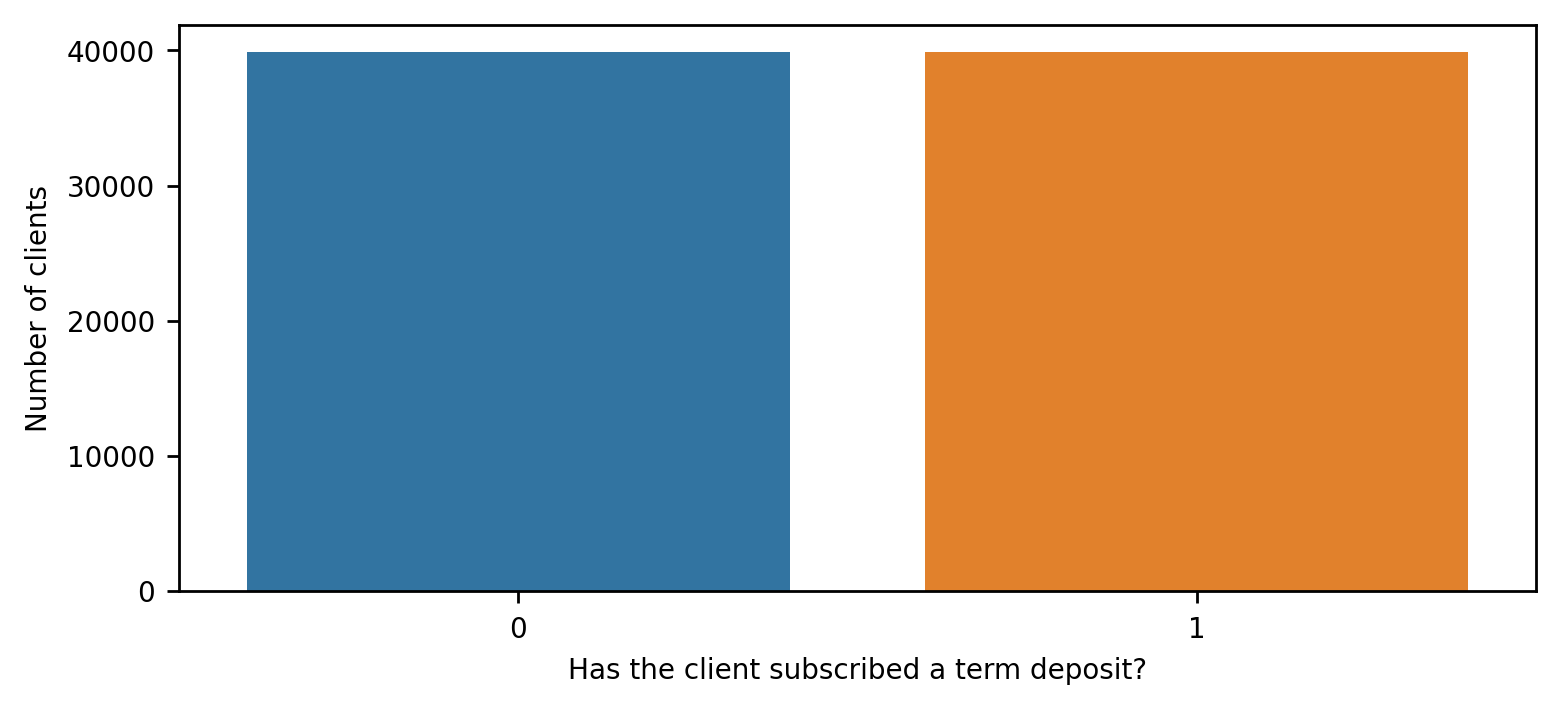

In [33]:
# Counterplot corresponding to y column of df_upsampled
sns.countplot(x='Output', data=df_upsampled, figure=plt.figure(figsize=(7,3), dpi=250))
plt.xlabel('Has the client subscribed a term deposit?', fontsize=8)
plt.ylabel('Number of clients', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

Now we are ready to define some prediction models in order to choose the best one as the final classifier. Before, we need to split up the dataset to make the training and testing datasets.

In [34]:
# We split up df_SMOTE and df_upsampled
X_train_SMOTE, X_test_SMOTE, y_train_SMOTE, y_test_SMOTE = train_test_split(X_SMOTE, y_SMOTE, test_size=0.15, random_state=2)
X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(X_upsampled, y_upsampled, test_size=0.15, random_state=4)

In [35]:
# We check the shape of the split dataframes
print('X_train_SMOTE.shape =', X_train_SMOTE.shape,
      'X_test_SMOTE.shape =', X_test_SMOTE.shape,
      'y_train_SMOTE.shape =', y_train_SMOTE.shape,
      'y_test_SMOTE.shape =', y_test_SMOTE.shape)

print('X_train_upsampled.shape =', X_train_upsampled.shape,
      'X_test_upsampled.shape =', X_test_upsampled.shape,
      'y_train_upsampled.shape =', y_train_upsampled.shape,
      'y_test_upsampled.shape =', y_test_upsampled.shape)

X_train_SMOTE.shape = (67867, 12) X_test_SMOTE.shape = (11977, 12) y_train_SMOTE.shape = (67867,) y_test_SMOTE.shape = (11977,)
X_train_upsampled.shape = (67867, 12) X_test_upsampled.shape = (11977, 12) y_train_upsampled.shape = (67867,) y_test_upsampled.shape = (11977,)


Let us define the machine learning models we will use.

In [36]:
RFC = RandomForestClassifier(n_jobs=-1)
KNN = KNeighborsClassifier(n_jobs=-1)
XGBC = XGBClassifier(max_leaves=0, n_jobs=-1)

# We need to define the distributions of hyperparameters from where will be sampled
# Random forest
RFC_dist = dict(n_estimators = [k for k in range(1, 201)],
                criterion = ['gini', 'entropy', 'log_loss'],
                max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10],
                min_samples_split = [k for k in range(1, 51)],
                min_samples_leaf = [k for k in range(1, 26)],
                max_leaf_nodes = [k for k in range(101)],
                min_impurity_decrease = uniform(loc=0, scale=1),
                bootstrap = [True, False])

# K-Neighbors
KNN_dist = dict(n_neighbors = [k for k in range(2, 201)],
                weights = ['uniform', 'distance'],
                algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'],
                p = [k for k in range(1, 15)])

# XGB
XGBC_dist = dict(n_estimators = [k for k in range(1, 101)],
                 max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10],
                 grow_policy = [0, 1],
                 booster = ['gbtree', 'gblinear', 'dart'],
                 tree_method = ['exact', 'approx', 'hist'])

# Let us instanciate the random searchers of hyperparameters object
RFC_searcher_SMOTE = RandomizedSearchCV(RFC, RFC_dist, random_state=1)
RFC_searcher_upsampled = RandomizedSearchCV(RFC, RFC_dist, random_state=2)
KNN_searcher_SMOTE = RandomizedSearchCV(KNN, KNN_dist, random_state=3)
KNN_searcher_upsampled = RandomizedSearchCV(KNN, KNN_dist, random_state=4)
XGBC_searcher_SMOTE = RandomizedSearchCV(XGBC, XGBC_dist, random_state=5)
XGBC_searcher_upsampled = RandomizedSearchCV(XGBC, XGBC_dist, random_state=6)

# Let us search the best fit hyperparameters
t_i = time.time()
RFC_search_SMOTE = RFC_searcher_SMOTE.fit(X_train_SMOTE, y_train_SMOTE)
print("RFC_search_SMOTE finished")
RFC_search_upsampled = RFC_searcher_upsampled.fit(X_train_upsampled, y_train_upsampled)
print("RFC_search_upsampled finished")
KNN_search_SMOTE = KNN_searcher_SMOTE.fit(X_train_SMOTE, y_train_SMOTE)
print("KNN_search_SMOTE finished")
KNN_search_upsampled = KNN_searcher_upsampled.fit(X_train_upsampled, y_train_upsampled)
print("KNN_search_upsampled finished")
XGBC_search_SMOTE = XGBC_searcher_SMOTE.fit(X_train_SMOTE, y_train_SMOTE)
print("XGBC_search_SMOTE finished")
XGBC_search_upsampled = XGBC_searcher_upsampled.fit(X_train_upsampled, y_train_upsampled)
print("XGBC_search_upsampled finished")

print("Process of finding the best hyperparameters finished. It took: ", (time.time() - t_i)/60, "min")

# The best fit hyperparameters are
print('RFC_SMOTE - Hyperparameters: ', RFC_search_SMOTE.best_params_)
print('============================================================')
print('RFC_upsampled - Hyperparameters: ', RFC_search_upsampled.best_params_)
print('============================================================')
print('KNN_SMOTE - Hyperparameters: ', KNN_search_SMOTE.best_params_)
print('============================================================')
print('KNN_upsampled - Hyperparameters: ', KNN_search_upsampled.best_params_)
print('============================================================')
print('XGBC_SMOTE - Hyperparameters: ', XGBC_search_SMOTE.best_params_)
print('============================================================')
print('XGBC_upsampled - Hyperparameters: ', XGBC_search_upsampled.best_params_)

RFC_search_SMOTE finished
RFC_search_upsampled finished
KNN_search_SMOTE finished
KNN_search_upsampled finished
[21:43:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "grow_policy", "max_depth", "max_leaves", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:43:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:43:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_164511776

[21:43:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "grow_policy", "max_depth", "max_leaves", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:43:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:43:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "grow_policy", "max_depth", "max_leaves", "tree_method" } might not

[21:43:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "grow_policy", "max_depth", "max_leaves", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:43:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:43:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "grow_policy", "max_depth", "max_leaves", "tree_method" } might not

[21:43:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "grow_policy", "max_depth", "max_leaves", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:43:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:43:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "grow_policy", "max_depth", "max_leaves", "tree_method" } might not

Now we have the best fit hyperparameters, we can use them to train the models. This would lead us to the best case scenario to make predictions.

In [37]:
# Let us reinstanciate the classifier objects again, but this time with the best fit hyperparameters
# We haven't pretrained a LR classifier, but we name it 'bestfit' to avoid confusion
LR_bestfit_SMOTE = LogisticRegression(random_state=5, max_iter=1000, n_jobs=-1)

LR_bestfit_upsampled = LogisticRegression(random_state=6, max_iter=1000, n_jobs=-1)

RFC_bestfit_SMOTE = RandomForestClassifier(n_estimators = RFC_search_SMOTE.best_params_['n_estimators'],
                                           criterion = RFC_search_SMOTE.best_params_['criterion'],
                                           max_depth = RFC_search_SMOTE.best_params_['max_depth'],
                                           min_samples_split = RFC_search_SMOTE.best_params_['min_samples_split'],
                                           min_samples_leaf = RFC_search_SMOTE.best_params_['min_samples_leaf'],
                                           max_leaf_nodes = RFC_search_SMOTE.best_params_['max_leaf_nodes'],
                                           min_impurity_decrease = RFC_search_SMOTE.best_params_['min_impurity_decrease'],
                                           bootstrap = RFC_search_SMOTE.best_params_['bootstrap'],
                                           n_jobs=-1)

RFC_bestfit_upsampled = RandomForestClassifier(n_estimators = RFC_search_upsampled.best_params_['n_estimators'],
                                           criterion = RFC_search_upsampled.best_params_['criterion'],
                                           max_depth = RFC_search_upsampled.best_params_['max_depth'],
                                           min_samples_split = RFC_search_upsampled.best_params_['min_samples_split'],
                                           min_samples_leaf = RFC_search_upsampled.best_params_['min_samples_leaf'],
                                           max_leaf_nodes = RFC_search_upsampled.best_params_['max_leaf_nodes'],
                                           min_impurity_decrease = RFC_search_upsampled.best_params_['min_impurity_decrease'],
                                           bootstrap = RFC_search_upsampled.best_params_['bootstrap'],
                                           n_jobs=-1)

KNN_bestfit_SMOTE = KNeighborsClassifier(n_neighbors = KNN_search_SMOTE.best_params_['n_neighbors'],
                                         weights = KNN_search_SMOTE.best_params_['weights'],
                                         algorithm = KNN_search_SMOTE.best_params_['algorithm'],
                                         p = KNN_search_SMOTE.best_params_['p'],
                                         n_jobs=-1)

KNN_bestfit_upsampled = KNeighborsClassifier(n_neighbors = KNN_search_upsampled.best_params_['n_neighbors'],
                                         weights = KNN_search_upsampled.best_params_['weights'],
                                         algorithm = KNN_search_upsampled.best_params_['algorithm'],
                                         p = KNN_search_upsampled.best_params_['p'],
                                         n_jobs=-1)

XGBC_bestfit_SMOTE = XGBClassifier(n_estimators = XGBC_search_SMOTE.best_params_['n_estimators'],
                                   max_depth = XGBC_search_SMOTE.best_params_['max_depth'],
                                   grow_policy = XGBC_search_SMOTE.best_params_['grow_policy'],
                                   booster = XGBC_search_SMOTE.best_params_['booster'],
                                   tree_method = XGBC_search_SMOTE.best_params_['tree_method'],
                                   n_jobs=-1)

XGBC_bestfit_upsampled = XGBClassifier(n_estimators = XGBC_search_upsampled.best_params_['n_estimators'],
                                   max_depth = XGBC_search_upsampled.best_params_['max_depth'],
                                   grow_policy = XGBC_search_upsampled.best_params_['grow_policy'],
                                   booster = XGBC_search_upsampled.best_params_['booster'],
                                   tree_method = XGBC_search_upsampled.best_params_['tree_method'],
                                   n_jobs=-1)

Now we have reinstantiated the classifiers, we have to proceed to train them so then we can evaluate the metrics in order to compare them and see which one do the best in predict the suscription.

In [38]:
# It is better if we put all the classifiers in a dictionary
classifiers = {"LR_SMOTE": LR_bestfit_SMOTE,
               "LR_upsampled": LR_bestfit_upsampled,
               "RFC_SMOTE": RFC_bestfit_SMOTE,
               "RFC_upsampled": RFC_bestfit_upsampled,
               "KNN_SMOTE": KNN_bestfit_SMOTE,
               "KNN_upsampled": KNN_bestfit_upsampled,
               "XGBC_SMOTE": XGBC_bestfit_SMOTE,
               "XGBC_upsampled": XGBC_bestfit_upsampled}

Let us train the classifiers.

In [39]:
for key in classifiers:
    # Get classifier
    classifier = classifiers[key]
    
    # Fit classifier
    if key.find('SMOTE') != -1:
        classifier.fit(X_train_SMOTE, y_train_SMOTE)
    else:
        classifier.fit(X_train_upsampled, y_train_upsampled)
        
    # Save fitted classifier
    classifiers[key] = classifier

[12:53:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "grow_policy", "max_depth", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:53:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "grow_policy", "max_depth", "tree_method" } might not be used.

  This could be a

We have trained the models. Now it is time to make some predictions in order to evaluate the precision of them. As same as before, we will save the predictions in a dictionary.

In [40]:
# Predictions dictionary
predictions = {"LR_SMOTE": None,
               "LR_upsampled": None,
               "RFC_SMOTE": None,
               "RFC_upsampled": None,
               "KNN_SMOTE": None,
               "KNN_upsampled": None,
               "XGBC_SMOTE": None,
               "XGBC_upsampled": None}

for key in classifiers:
    # Make a prediction on test set
    if key.find('SMOTE') != -1:
        predictions[key] = classifiers[key].predict(X_test_SMOTE)
    else:
        predictions[key] = classifiers[key].predict(X_test_upsampled)

Now, we need to check the predictions to choose the best model. We will start with the accuracy score, which is defined as the rate of all correct predictions to the number of total predictions. Since it is a problem of binary classification, this score can be written as:

$$ A = \frac{TP + TN}{TP + FP + FN + TN}. $$

In the equation above, TP stands for $\textit{true positive}$, TN for $\textit{true negative}$, FP for $\textit{false positive}$ and FN for $\textit{false negative}$.

In [41]:
# Check the accuracy score
for key in predictions:
    if key.find('SMOTE') != -1:
        print('{} - Accuracy score: '.format(key), accuracy_score(y_test_SMOTE, predictions[key]))
    else:
        print('{} - Accuracy score: '.format(key), accuracy_score(y_test_upsampled, predictions[key]))

LR_SMOTE - Accuracy score:  0.8266677799114971
LR_upsampled - Accuracy score:  0.8095516406445687
RFC_SMOTE - Accuracy score:  0.4973699590882525
RFC_upsampled - Accuracy score:  0.49962427986975033
KNN_SMOTE - Accuracy score:  0.9222676797194623
KNN_upsampled - Accuracy score:  0.9119145027970277
XGBC_SMOTE - Accuracy score:  0.829172580779828
XGBC_upsampled - Accuracy score:  0.8094681472822911


The precision score is defined as:

$$ P = \frac{TP}{TP + FP}. $$

In [42]:
# Check the precision score
for key in predictions:
    if key.find('SMOTE') != -1:
        print('{} - Precision score: '.format(key), precision_score(y_test_SMOTE, predictions[key]))
    else:
        print('{} - Precision score: '.format(key), precision_score(y_test_upsampled, predictions[key]))

LR_SMOTE - Precision score:  0.824878620458731
LR_upsampled - Precision score:  0.8182912154031288
RFC_SMOTE - Precision score:  0.4973699590882525
RFC_upsampled - Precision score:  0.49962427986975033
KNN_SMOTE - Precision score:  0.8658998252766453
KNN_upsampled - Precision score:  0.8501207557891746
XGBC_SMOTE - Precision score:  0.8100523228159188
XGBC_upsampled - Precision score:  0.8096353295416527


The recall score is defined as:

$$ R = \frac{TP}{TP + FN}. $$

In [43]:
# Check the recall score
for key in predictions:
    if key.find('SMOTE') != -1:
        print('{} - Recall score: '.format(key), recall_score(y_test_SMOTE, predictions[key]))
    else:
        print('{} - Recall score: '.format(key), recall_score(y_test_upsampled, predictions[key]))

LR_SMOTE - Recall score:  0.8270941749202618
LR_upsampled - Recall score:  0.7954545454545454
RFC_SMOTE - Recall score:  1.0
RFC_upsampled - Recall score:  1.0
KNN_SMOTE - Recall score:  0.9983213026691288
KNN_upsampled - Recall score:  1.0
XGBC_SMOTE - Recall score:  0.8576464663421185
XGBC_upsampled - Recall score:  0.8088235294117647


The specificity score is said to be the recall score but for the actual negative values. It is defined as:

$$ S = \frac{TN}{TN + FP}. $$

In [44]:
# Check the specificity score
for key in predictions:
    if key.find('SMOTE') != -1:
        print('{} - Specificity score: '.format(key), recall_score(y_test_SMOTE, predictions[key], pos_label=0))
    else:
        print('{} - Specificity score: '.format(key), recall_score(y_test_upsampled, predictions[key], pos_label=0))

LR_SMOTE - Specificity score:  0.8262458471760797
LR_upsampled - Specificity score:  0.8236275654930753
RFC_SMOTE - Specificity score:  0.0
RFC_upsampled - Specificity score:  0.0
KNN_SMOTE - Specificity score:  0.8470099667774086
KNN_upsampled - Specificity score:  0.8239612881695311
XGBC_SMOTE - Specificity score:  0.8009966777408638
XGBC_upsampled - Specificity score:  0.8101117970966127


The tradeoff between recall and precision is known as F1 score. It is the harmonic mean between these two metrics, and its formulae is:

$$ F1 = \frac{2 \cdot P \cdot R}{P + R} = \frac{2TP}{2TP + FP + FN}. $$

In [45]:
# Check the F1 score
for key in predictions:
    if key.find('SMOTE') != -1:
        print('{} - F1 score: '.format(key), f1_score(y_test_SMOTE, predictions[key]))
    else:
        print('{} - F1 score: '.format(key), f1_score(y_test_upsampled, predictions[key]))

LR_SMOTE - F1 score:  0.8259849119865884
LR_upsampled - F1 score:  0.8067112956529107
RFC_SMOTE - F1 score:  0.6643247462919594
RFC_upsampled - F1 score:  0.6663326095428985
KNN_SMOTE - F1 score:  0.9274074074074075
KNN_upsampled - F1 score:  0.918989480150503
XGBC_SMOTE - F1 score:  0.8331702544031311
XGBC_upsampled - F1 score:  0.8092292258819596


As a final test of how good our predictors perform, we can check the confusion matrix for each of the models trained.

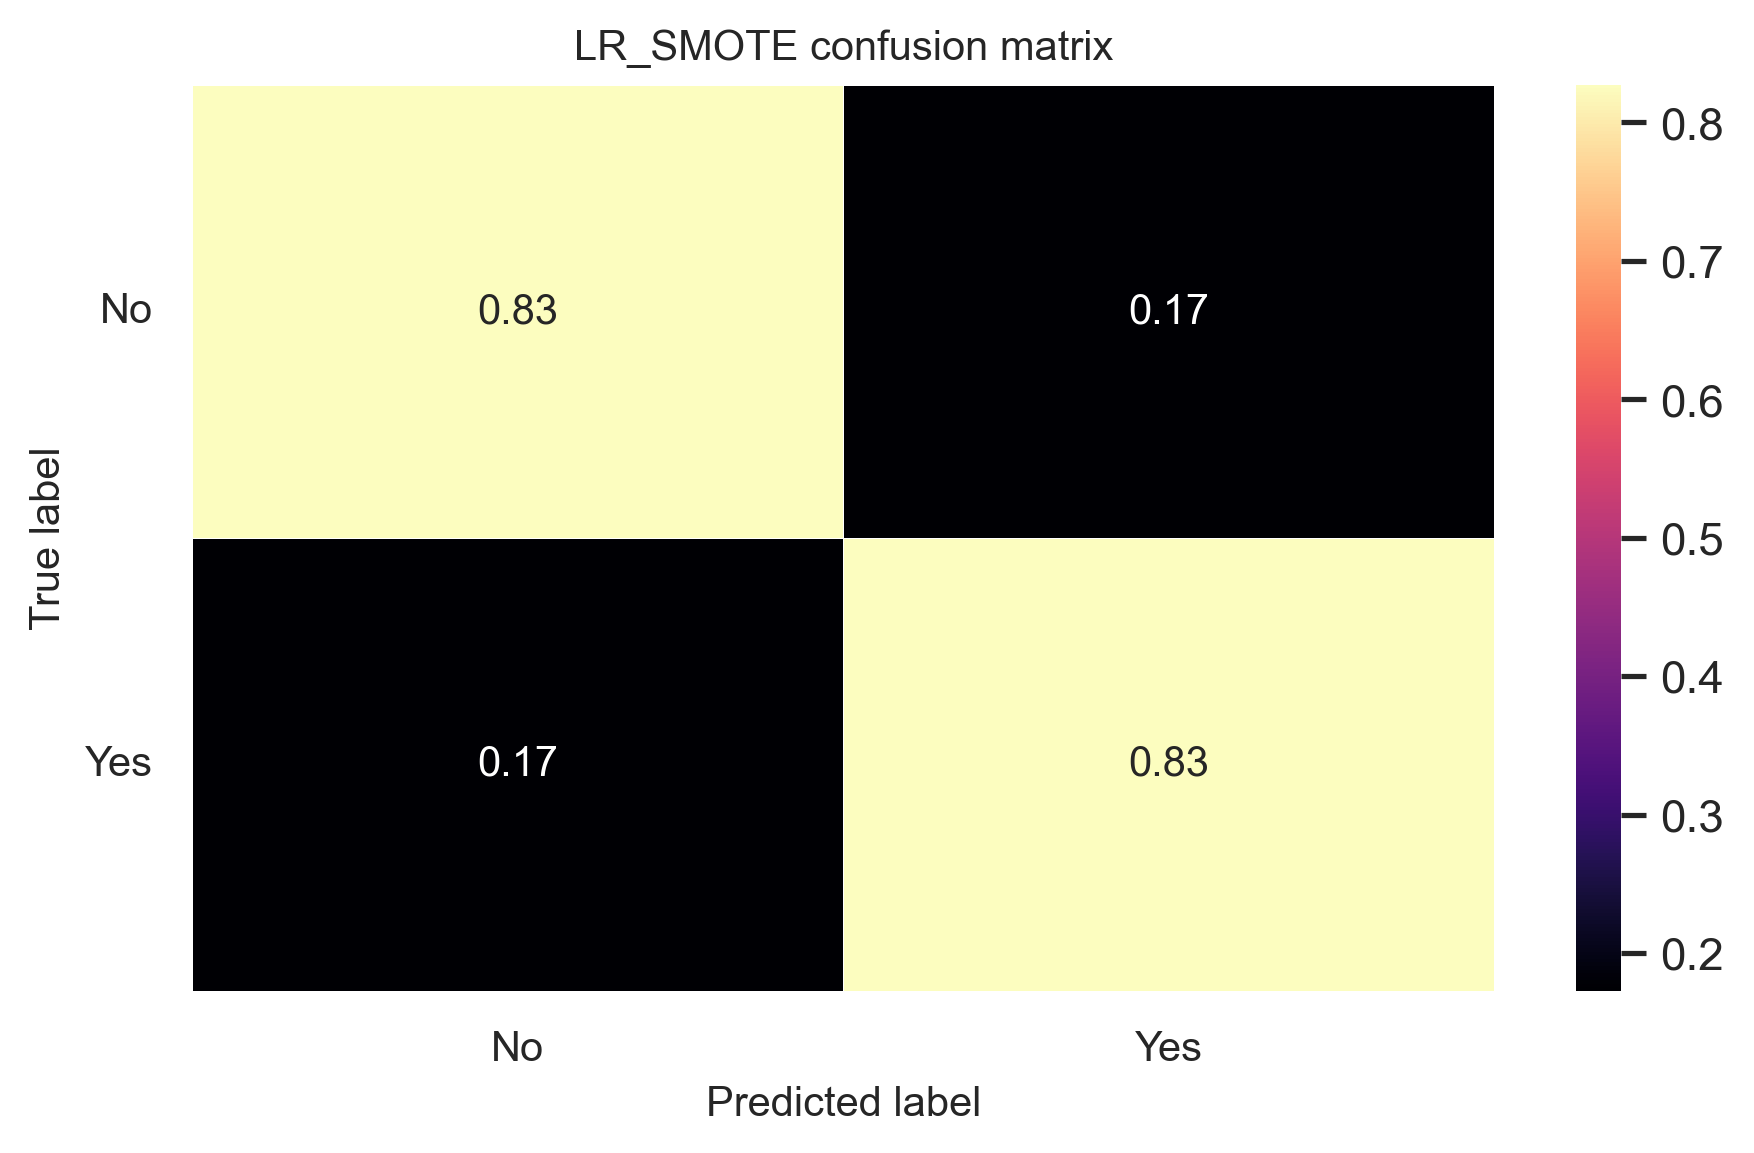

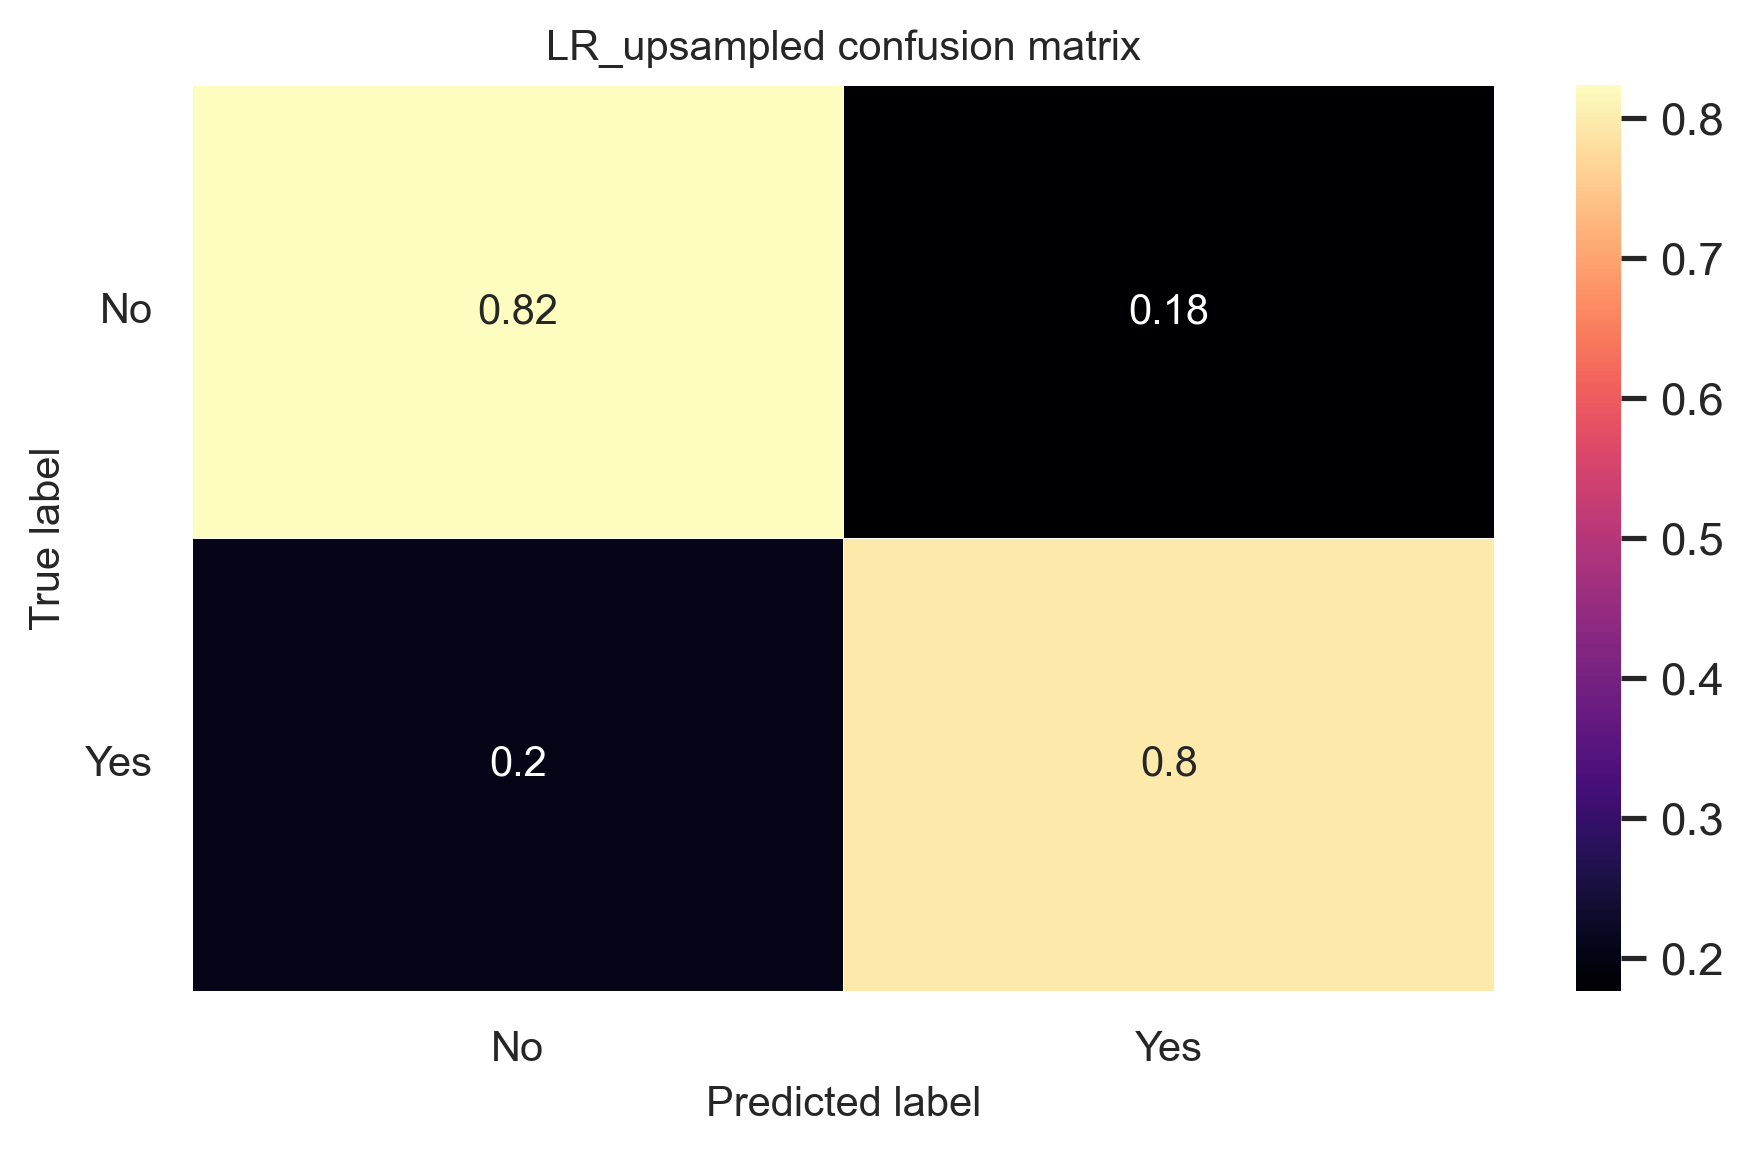

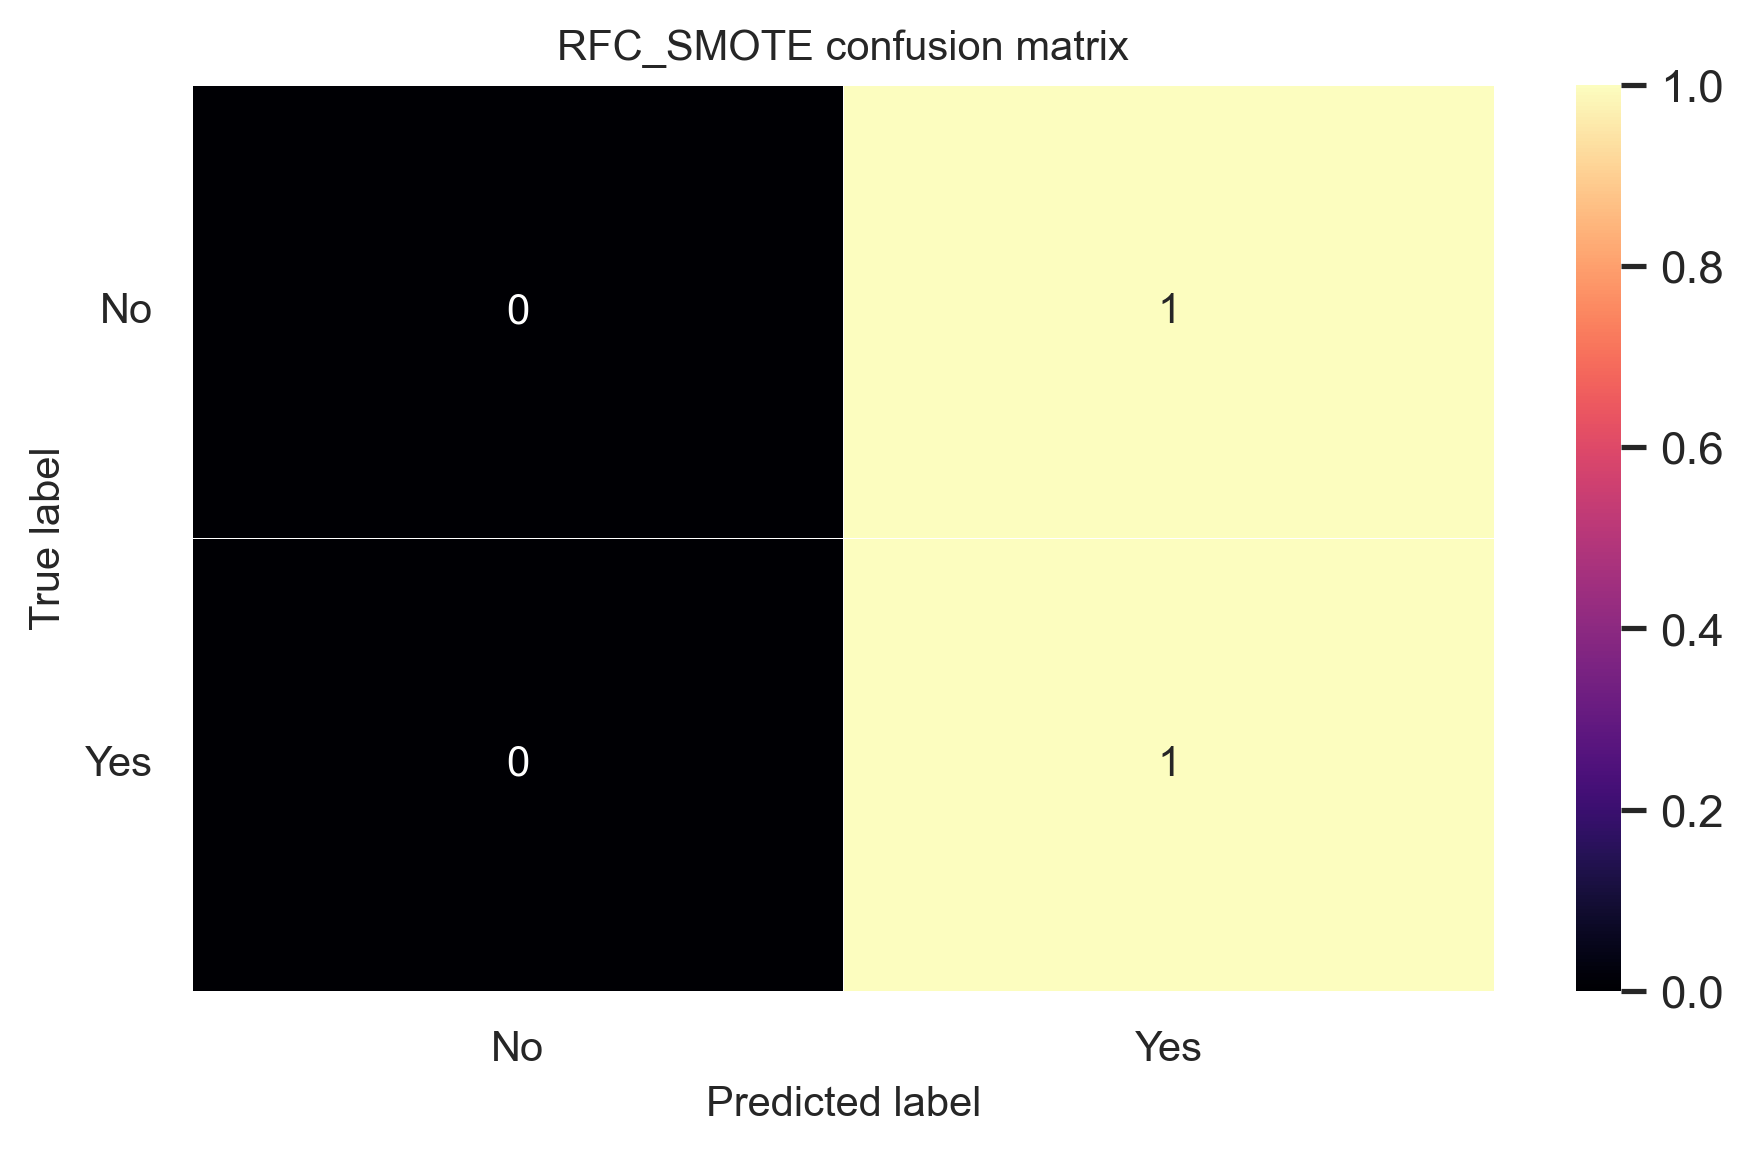

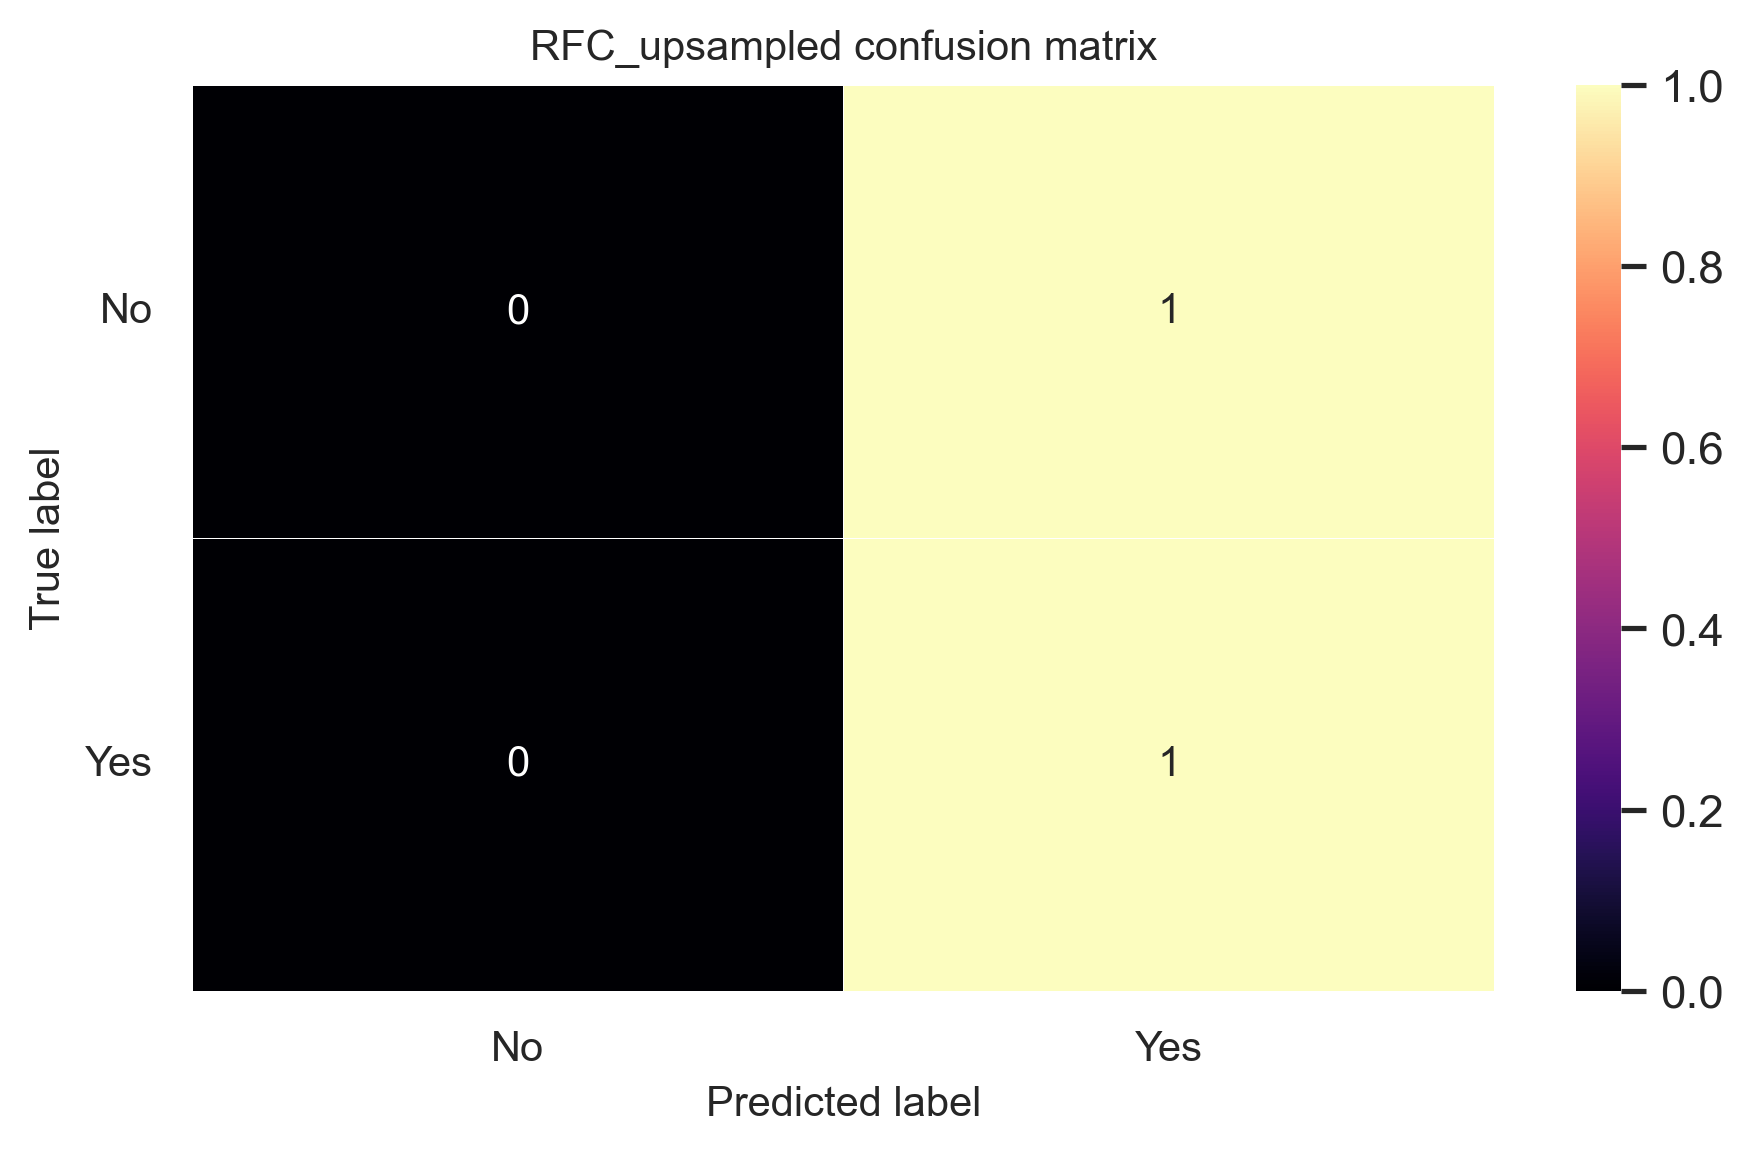

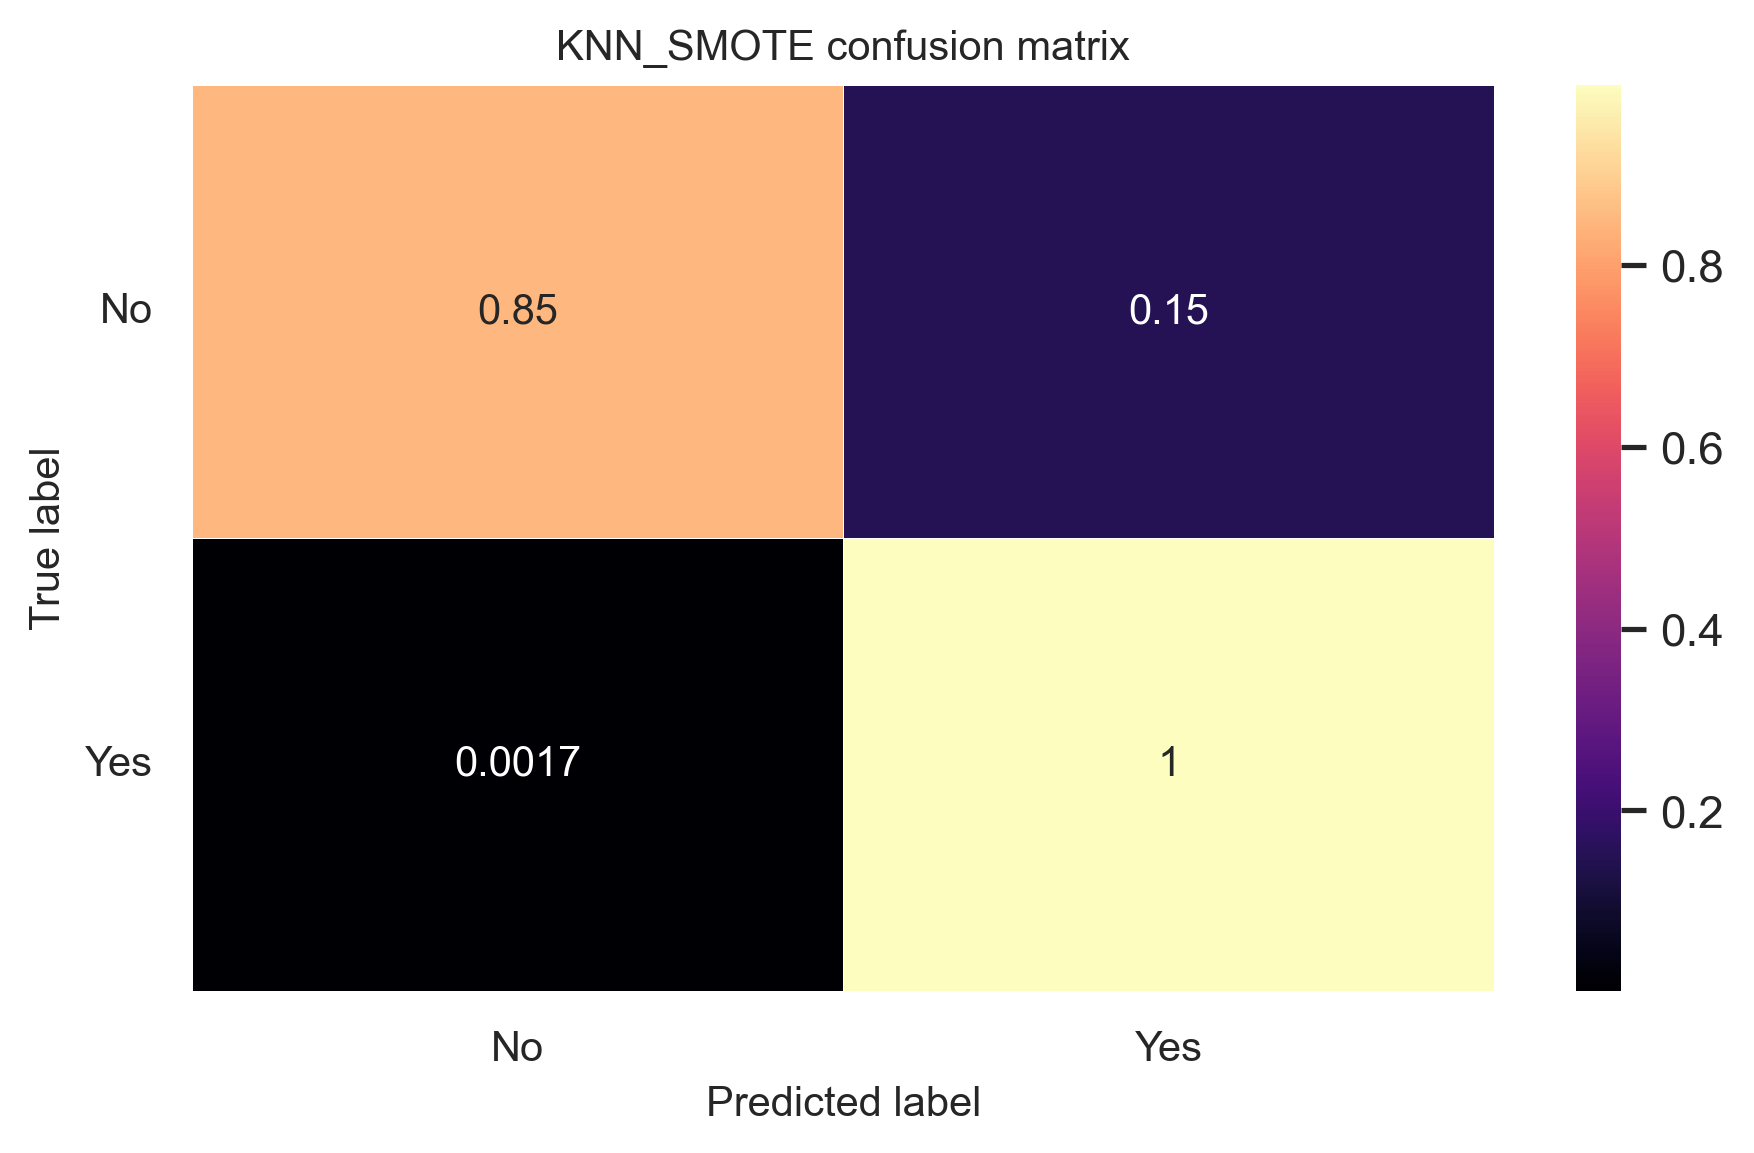

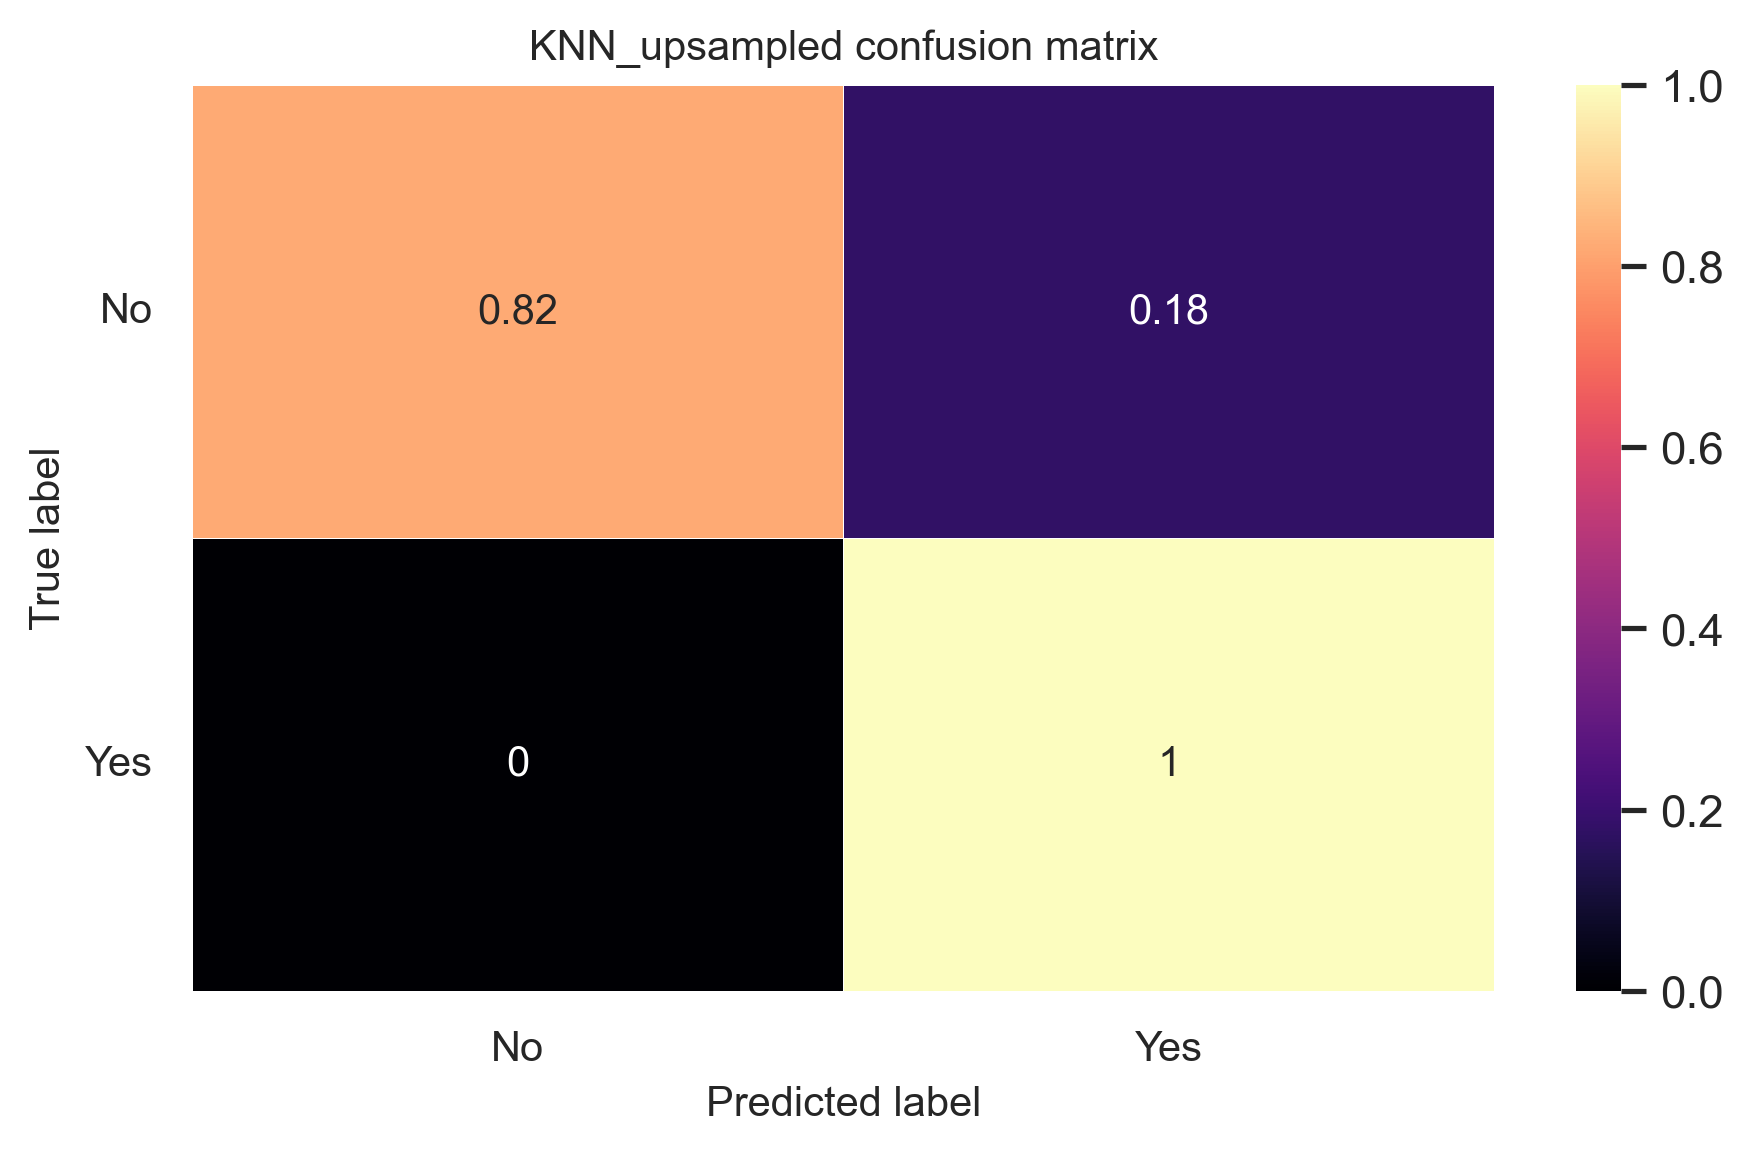

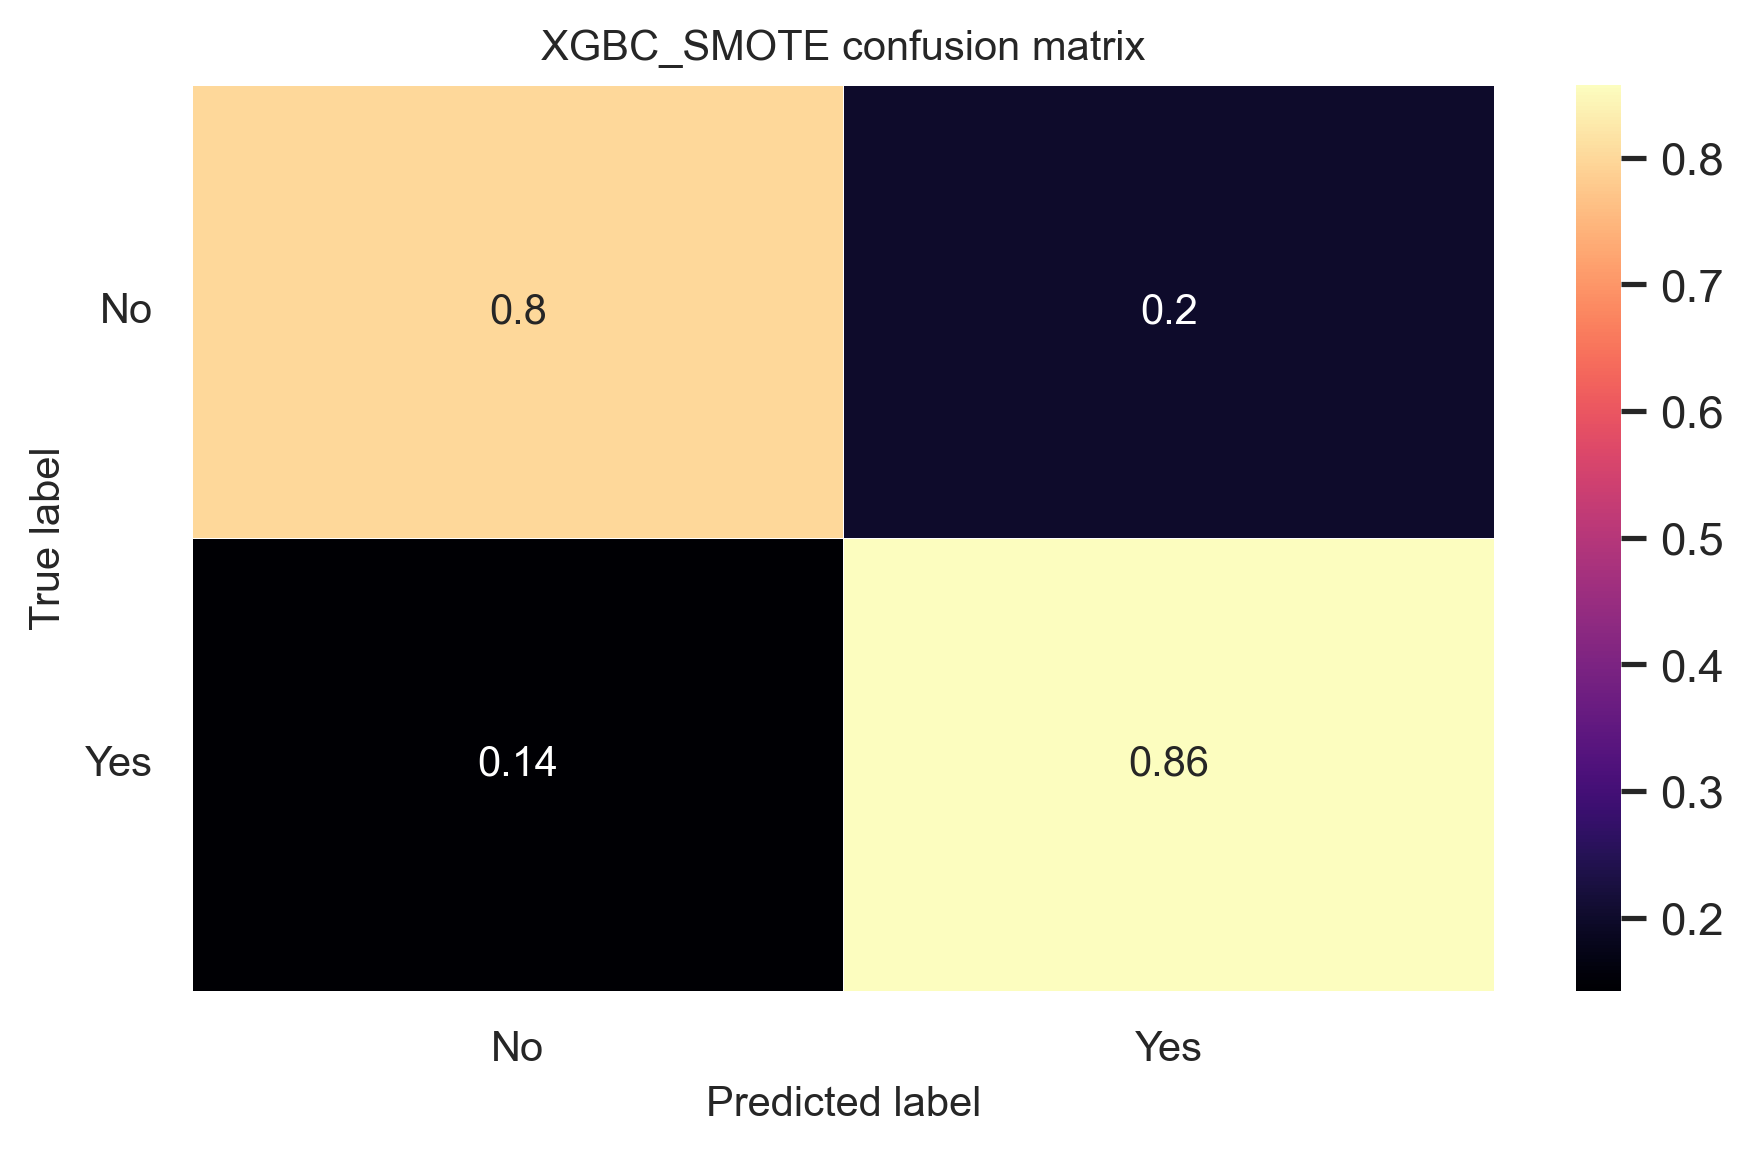

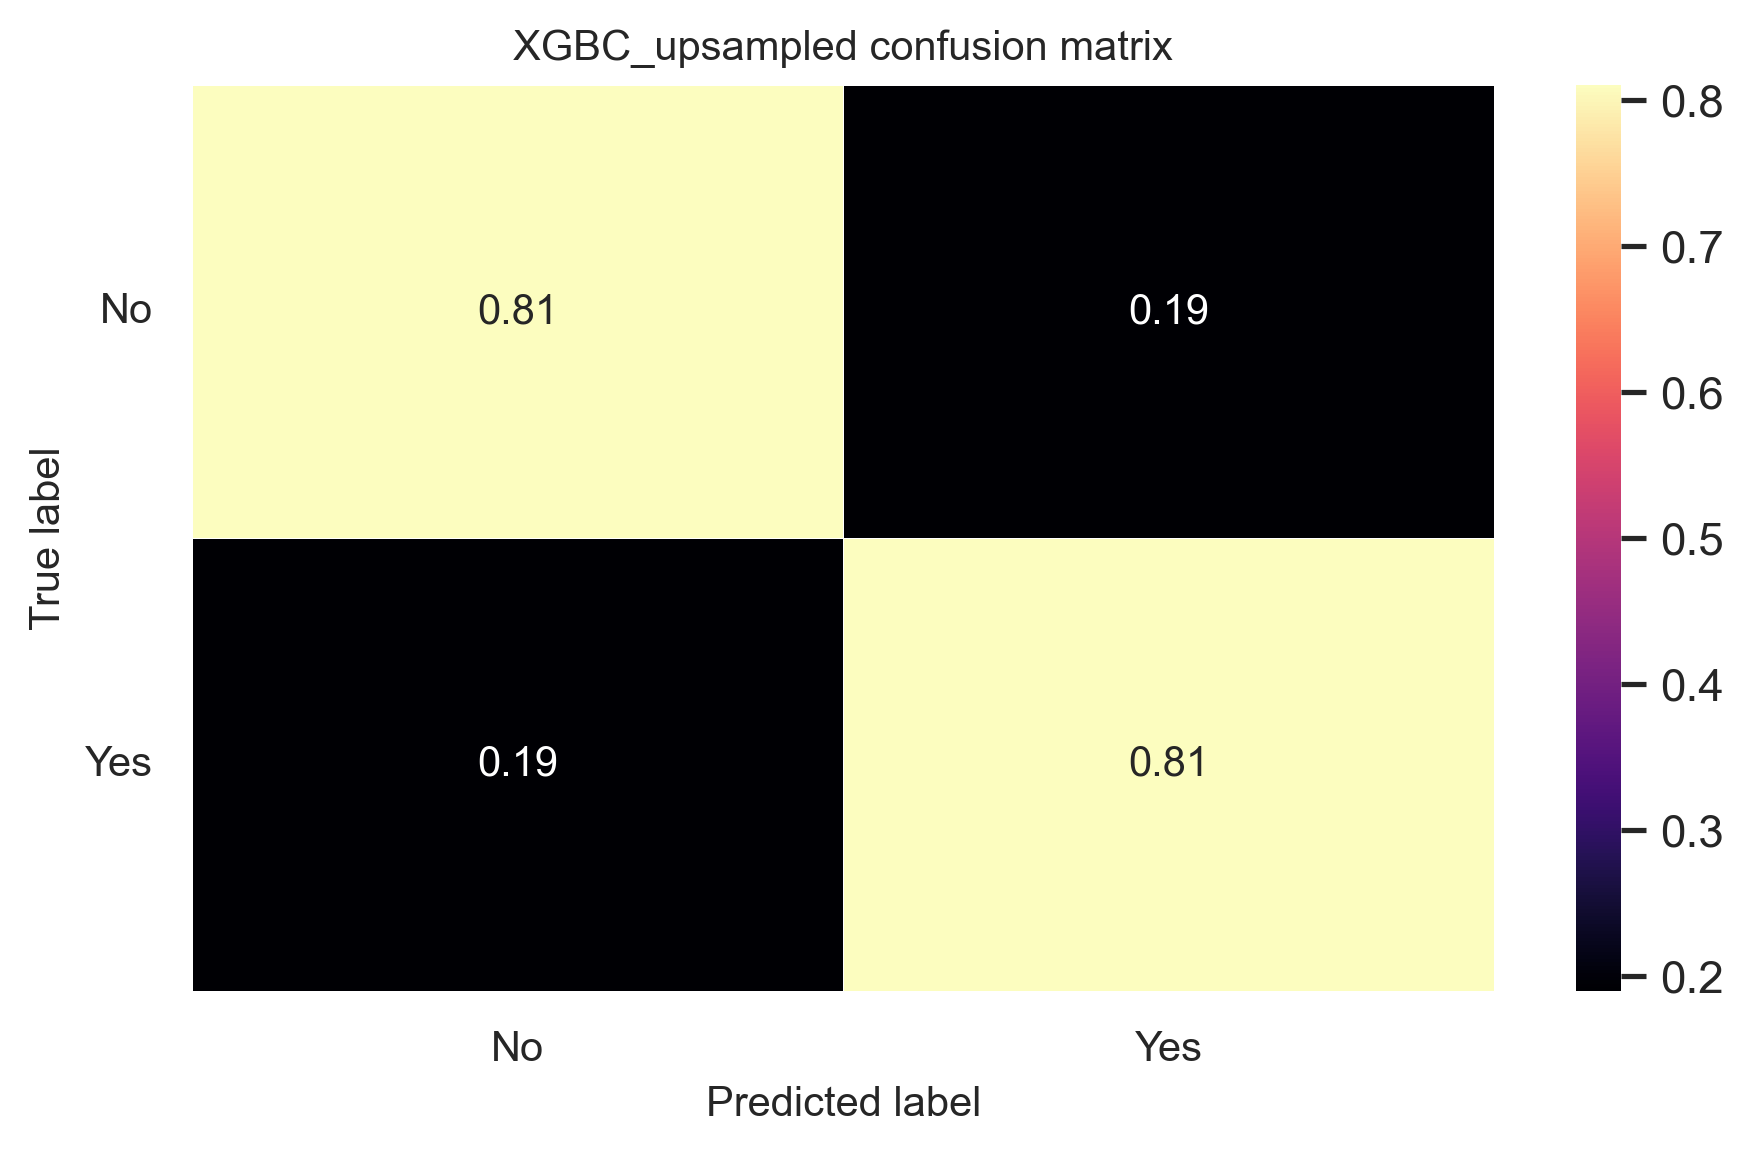

In [46]:
# Get and reshape confusion matrix data
cm = {"LR_SMOTE": None,
      "LR_upsampled": None,
      "RFC_SMOTE": None,
      "RFC_upsampled": None,
      "KNN_SMOTE": None,
      "KNN_upsampled": None,
      "XGBC_SMOTE": None,
      "XGBC_upsampled": None}

for key in cm:
    if key.find('SMOTE') != -1:
        cm[key] = confusion_matrix(y_test_SMOTE, predictions[key])
        cm[key] = cm[key].astype('float')/cm[key].sum(axis=1)[:, np.newaxis]
    else:
        cm[key] = confusion_matrix(y_test_upsampled, predictions[key])
        cm[key] = cm[key].astype('float')/cm[key].sum(axis=1)[:, np.newaxis]

def build_cm_plot(matrix, class_names, title):
    # Build the plot
    plt.figure(figsize=(7,4), dpi=300)
    sns.set(font_scale=1.)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10}, cmap=plt.cm.magma, linewidths=0.2)

    tick_marks = np.arange(len(class_names)) + 0.5
    tick_marks2 = tick_marks
    plt.xticks(tick_marks, class_names, rotation=0, size=10)
    plt.yticks(tick_marks2, class_names, rotation=0, size=10)
    plt.xlabel('Predicted label', size=10)
    plt.ylabel('True label', size=10)
    plt.title(title, size=10)
    plt.show()

for key in cm:
    build_cm_plot(cm[key], ['No', 'Yes'], key+' confusion matrix')

As we can see, based on the metric analysis made above, there are a clear best classificator, which is the KNN model trained on SMOTE data. It performs very well at the time to predict the 'Yes' cases and knows how to handle the 'No' predictions reasonably well.

#### References
[1] https://www.kaggle.com/code/residentmario/data-types-and-missing-values/tutorial

[2] https://stats.stackexchange.com/questions/5774/can-principal-component-analysis-be-applied-to-datasets-containing-a-mix-of-cont

[3] https://towardsdatascience.com/factor-analysis-of-mixed-data-5ad5ce98663c

[4] https://nextjournal.com/pc-methods/calculate-pc-mixed-data?change-id=CWQNw1kVRgQMFFzobMC2bo&node-id=d4243af6-f940-41fc-8ffa-a235bc135601

[5] https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/

[6] https://medium.com/swlh/how-to-remember-all-these-classification-concepts-forever-761c065be33